# CIS6800: Project 3: SOLO and FPN (Instance Segmentation)
### Due:
* Part (a) Oct. 1 at 11:59 p.m.
* Part (b) Oct. 8 at 11:59 p.m.

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects. You may use ChatGPT, but you need to document how you use it.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train. Or use colab cpu instance for debugging
* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.


The SOLO paper: https://arxiv.org/pdf/1912.04488.pdf


## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
!pip install pytorch-lightning

In [1]:
try:
    import dataset
    import model
    # import train
    # import inference
except ModuleNotFoundError:
    pass

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this.

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import pytorch_lightning as pl
from sklearn import metrics
from matplotlib import patches
from torchvision.utils import draw_bounding_boxes
from PIL import ImageColor
from dataset import BuildDataset
from dataset import BuildDataLoader
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import matplotlib.patches as patches
from PIL import ImageColor, ImageFont
import cv2
import os
import copy
import torch
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import torch.nn.functional as F
from pytorch_lightning.loggers import tensorboard
import torchvision
import torchvision.transforms 
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR

import warnings
warnings.filterwarnings("ignore")


# CUDA for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using the GPU!")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using the mps!")
else:
    device = torch.device("cpu")
    print("WARNING: Could not find GPU! Using CPU only")
seed = 21
torch.manual_seed(seed);

Using the mps!


In [3]:
def visualize_dataset_sample(image, label, mask, bbox):
    mask_converted = mask.bool()
    img = image[:, :, 11:-11]
    #font (str) – A filename containing a TrueType font. 
    # the loader may also search in other directories /Library/Fonts/, 
    # /System/Library/Fonts/ and ~/Library/Fonts/ on macOS.

    #load default font from PIL lib
    # try:
    #     font="/Library/Fonts/Ariale Unicode.ttf"
    # except OSError as error:
    #     font=None
    trans_inv = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.255]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])
    re_pad = torch.nn.ZeroPad2d((11, 11, 0, 0))
    img_reconstruct = re_pad(trans_inv(img))
    img_reconstruct = (img_reconstruct.clamp(0, 1) * 255).to(torch.uint8)
    img_reconst_visualize = img_reconstruct.clone()
    annotations = []  # List of annotations to draw on the image
    colors = {1: ('Vehicle', 'blue'), 2: ('People', 'green'), 3: ('Animal', 'red')}
    # #use this font to get a proper size of annotation
    # #if does not work; use default font
    # #you can specify your own font path according to your OS/ Directory
    # try:
    #     font_path="/Library/Fonts/"
    #     font = os.listdir(font_path)[0]
    #     img_op = draw_bounding_boxes(img_op, bbox, colors='red', width=2, font=font, font_size=35)
    # except OSError as error:
    #     img_op = draw_bounding_boxes(img_op, bbox, colors='red', width=2)
    if mask_converted.ndim == 2:
        # print("ouch")
        mask_converted = mask_converted[None, :, :]
    # for lab, mask in zip(label,mask_converted):
    #     annotation, color_name = colors.get(lab.item())
    #     annotations.append(annotation)
    #     color = torch.tensor(ImageColor.getrgb(color_name), dtype=torch.uint8)
    #     img_reconst_visualize[:, mask] = color[:, None]
    for mask, _, lab in zip(mask_converted, bbox, label):
        if lab.item() == 1:
            x = ImageColor.getrgb('blue')
            c = torch.tensor(x, dtype=torch.uint8)
            img_reconst_visualize[:, mask] = c[:, None]
            annotations.append("Vehicle")
        elif lab.item() == 2:
            x = ImageColor.getrgb('green')
            c = torch.tensor(x, dtype=torch.uint8)
            img_reconst_visualize[:, mask] = c[:, None]
            annotations.append("People")
        elif lab.item() == 3:
            x = ImageColor.getrgb('red')
            c = torch.tensor(x, dtype=torch.uint8)
            img_reconst_visualize[:, mask] = c[:, None]
            annotations.append("Animal")
    # for i, single_mask in enumerate(mask_converted):
    #     if single_mask.any():
    #         img_reconst_visualize[:, single_mask] = color[:, None]
    img_op = (img_reconstruct * (0.5) + img_reconst_visualize * 0.5).to(torch.uint8)
    #use this font to get a proper size of annotation
    #if does not work; use default font
    #you can specify your own font path according to your OS/ Directory
    try:
        font_path="/Library/Fonts/"
        font = os.listdir(font_path)[0]
        img_op = draw_bounding_boxes(img_op, bbox, labels=annotations, colors='red', width=2, font=font, font_size=35)
    except OSError as error:
        img_op = draw_bounding_boxes(img_op, bbox, labels=annotations, colors='red', width=2)
    img_disp = img_op
    return img_disp.permute(1, 2, 0)

In [4]:
# replace the path with your own path
imgs_path = '/Users/ojasm/Desktop/UPenn/Fall 2023/CIS 680/project 3/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '/Users/ojasm/Desktop/UPenn/Fall 2023/CIS 680/project 3/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '/Users/ojasm/Desktop/UPenn/Fall 2023/CIS 680/project 3/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '/Users/ojasm/Desktop/UPenn/Fall 2023/CIS 680/project 3/hw3_mycocodata_bboxes_comp_zlib.npy'
path = [imgs_path, masks_path, labels_path, bboxes_path]

# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

In [5]:
dataset = BuildDataset(path)
# print("dataset size: ", len(dataset))
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# push the randomized training data into the dataloader
batch_size = 2
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

mask_color_list = ["jet", "ocean", "Spectral", "spring", "cool"]


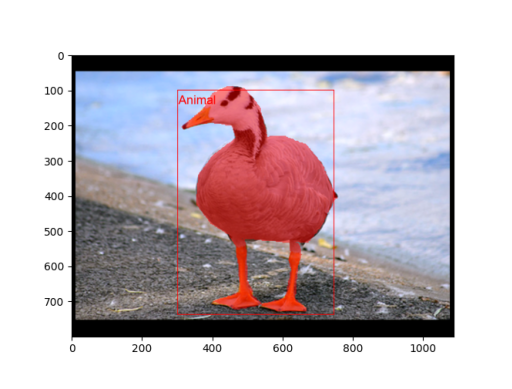

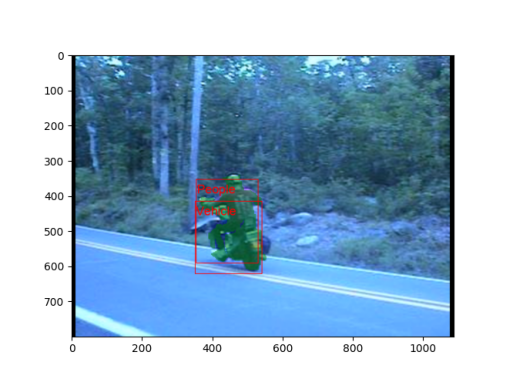

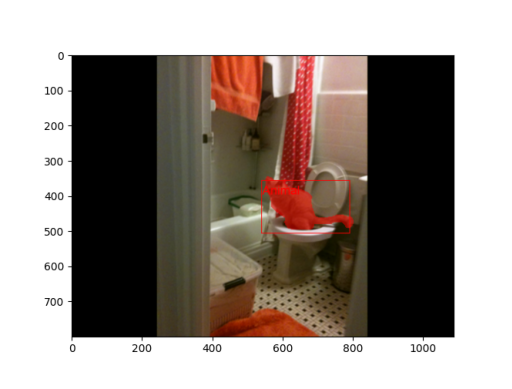

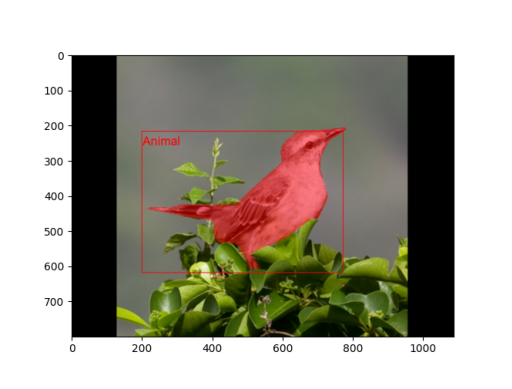

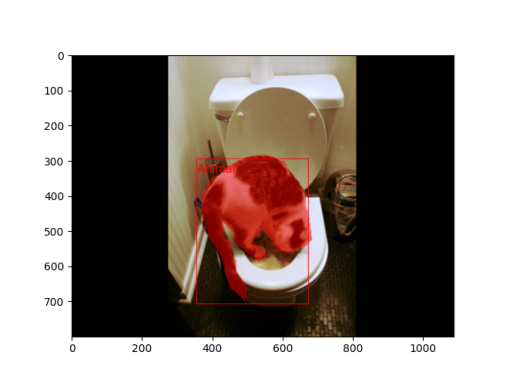

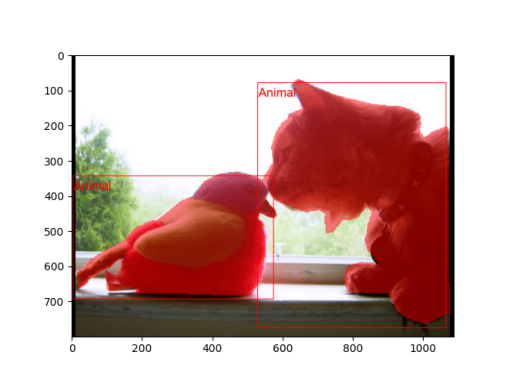

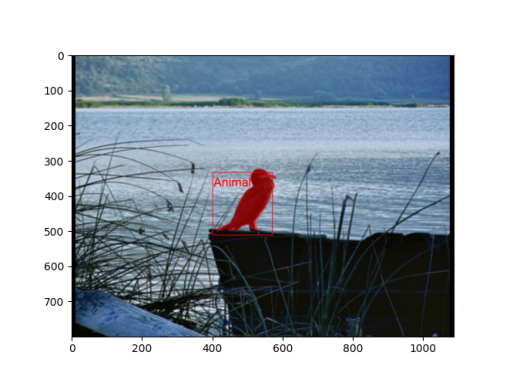

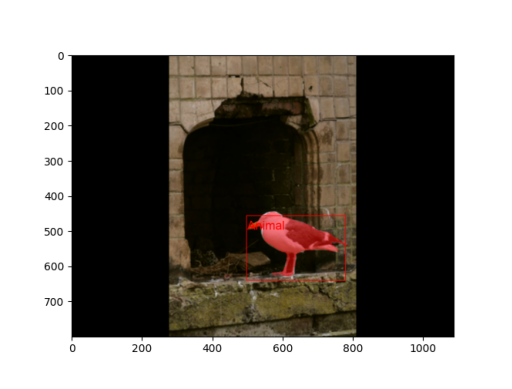

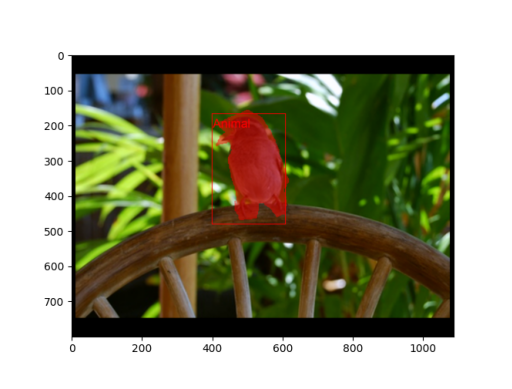

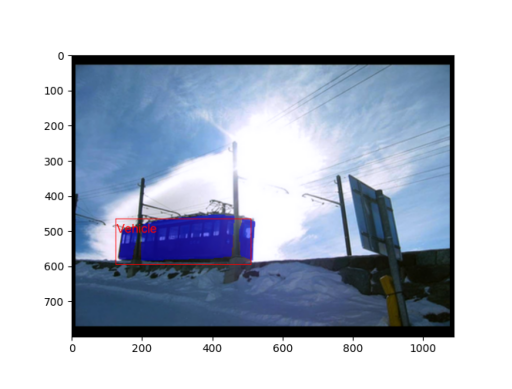

In [ ]:
plot_idx = 0
flag = True
for iter, data in enumerate(train_loader, 0):

    img, l, mask, bbox = [data[i] for i in range(len(data))]
    # check flag
    assert img.shape == (batch_size, 3, 800, 1088)
    assert len(mask) == batch_size

    img = [img_img.to(device) for img_img in img]
    l = [label_img.to(device) for label_img in l]
    mask = [mask_img.to(device) for mask_img in mask]
    bbox = [bbox_img.to(device) for bbox_img in bbox]
    # plot the origin img
    # print(batch_size)
    for i in range(batch_size):
        ## TODO: plot images with annotations
        op_img = visualize_dataset_sample(img[i], l[i], mask[i], bbox[i])
        plt.imshow(op_img)
        plt.savefig("Test visualtrainset"+str(plot_idx)+".png")
        plt.show()
        plot_idx += 1

        if plot_idx == 10:
            flag = False
            break
    if flag == False:
        break

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.

#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [8]:
#make sure all the tensors are on the same device in the below function

#so first check all the devices of the tensors using get_device() function for every variable
#then use to(device) function to move them to the same device

def visualize_targets_data_sample(target_m, active_mask_, target_category, img):
  # target_category = 0
  for i in range(len(target_m)):
    for j in range(len(target_m[i])):
      m = (torch.zeros((img.shape[2],img.shape[3],img.shape[1]))).to(device)
      # print(f"m device: {m.get_device()}")
      # m = m.to(device)
      blank_mask = (torch.clamp(img[i], 0, 1).permute(1, 2, 0))
      # print(f"blank_mask device: {blank_mask.get_device()}")
      plt.imshow(blank_mask)
      if sum(active_mask_[i][j]) == 0:
        plt.show()
        continue  
      # idx = 0
      idx = (active_mask_[i][j] > 0)
      mask = (target_m[i][j][idx,:,:]).unsqueeze(1)
      l = torch.flatten(target_category[i][j])[idx]
      # print(f"mask device: {mask.get_device()}")
      # print(f"l device: {l.get_device()}")
      inter_msk = F.interpolate(mask,(img.shape[2],img.shape[3]),mode='bilinear')
      # print(f"inter_msk device: {inter_msk.get_device()}")
      
      for j, l in enumerate(l):
        if l == 1:
          m[:,:,2] = m[:,:,2] + (inter_msk[j,0,:,:])
        elif l == 2:
          m[:,:,1] = m[:,:,1] + (inter_msk[j,0,:,:])
        elif l == 3:
          m[:,:,0] = m[:,:,0] + (inter_msk[j,0,:,:])

      idx_m = torch.where(m > 0)
      bigng_img = (torch.clamp((img[i,:,:,:]), 0, 1)).permute(1,2,0)
      bigng_img = bigng_img.to(device)
      # print(f"bigng_img device: {bigng_img.get_device()}")
      x = idx_m[0]
      img_mask = torch.clone(bigng_img)
      # img_mask = img_mask.to(device)
      # print(f"img_mask device: {img_mask.get_device()}")
      y = idx_m[1]
      img_mask[x,y,:] = 0
      opp_img = torch.clamp(((m + img_mask)), 0, 1)
      # print(f"opp_img device: {opp_img.get_device()}")
      plt.imshow(opp_img.cpu())
      plt.show()

In [23]:
class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone

        self.train_loss = []
        self.train_category_loss = []
        self.train_mask_loss = []

        self.val_loss = []
        self.val_category_loss = []
        self.val_msk_loss_epoch = []

        self.validation_step_outputs = []
        self.training_step_outputs = []

        self.category_convs = nn.ModuleList()
        self.category_gn = nn.ModuleList()
        self.category_relu = nn.ModuleList()
        self.category_out = nn.ModuleList()

        for _ in range(7):
            self.category_convs.append(nn.Conv2d(
                in_channels=self._default_cfg['in_channels'],
                out_channels=self._default_cfg['in_channels'],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ))
            self.category_gn.append(nn.GroupNorm(num_groups=32, num_channels=256))
            self.category_relu.append(nn.ReLU())

        self.category_out.append(nn.Conv2d(
            in_channels=self._default_cfg['in_channels'],
            out_channels=self._default_cfg['num_classes'] - 1,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        ))
        self.category_out.append(nn.Sigmoid())

        # Mask Network
        self.mask_convs = nn.ModuleList()
        self.mask_gn = nn.ModuleList()
        self.mask_relu = nn.ModuleList()
        self.mask_out = nn.ModuleList()

        self.mask_convs.append(nn.Conv2d(
                in_channels=self._default_cfg['in_channels'] + 2,
                out_channels=self._default_cfg['in_channels'],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ))
        self.mask_gn.append(nn.GroupNorm(num_groups=32, num_channels=256))
        self.mask_relu.append(nn.ReLU())

        for _ in range(6):
            self.mask_convs.append(nn.Conv2d(
                in_channels=self._default_cfg['in_channels'],
                out_channels=self._default_cfg['in_channels'],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ))
            self.mask_gn.append(nn.GroupNorm(num_groups=32, num_channels=256))
            self.mask_relu.append(nn.ReLU())

        for i in range(5):
            self.mask_out.append(nn.Conv2d(
                in_channels=self._default_cfg['in_channels'],
                out_channels=self._default_cfg['num_grids'][i] ** 2,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True
            ))

    def category_forward(self, x):
        for i in range(7):
            x = self.category_relu[i](self.category_gn[i](self.category_convs[i](x)))
        x = self.category_out[1](self.category_out[0](x))
        return x

    def mask_forward(self, x, i):
        x = self.mask_relu[0](self.mask_gn[0](self.mask_convs[0](x).unsqueeze(0)))
        for j in range(1,7):
            x = self.mask_relu[j](self.mask_gn[j](self.mask_convs[j](x)))
        x = self.category_out[1](self.mask_out[i](x))
        return x
    
    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward(self, images, eval):
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]
        l = len(feature_pyramid)
        h = 800
        w = 1088
        scaled_h = int(h/4)
        scaled_w = int(w/4)
        mask_pred_list = []
        category_pred_list = []
      
        for i, feature_map in enumerate(feature_pyramid):
          curr_strides = self._default_cfg["strides"][i]

          feature_h = 2*int(h/curr_strides)
          feature_w = 2*int(w/curr_strides)
          # print(f"h_f : {type(H_f)}")
          # print(f"w_f : {type(W_f)}")

          S = self._default_cfg["num_grids"][i]
          C = self._default_cfg["num_classes"]

          if eval:
            category_tensor = torch.zeros((batch_size, S, S, C-1))
            mask_tensor = torch.zeros((batch_size, S**2, scaled_h, scaled_w))       
          else : 
            category_tensor = torch.zeros((batch_size, C-1, S, S))
            mask_tensor = torch.zeros((batch_size, S**2, feature_h, feature_w))

          # print(f"len img: {len(images)}")
          # print(f"len feature_map: {len(feature_map)}")

          for batch_num, pyramid_img in enumerate(feature_map):

            if i == 0 or (l - 1):
              pyramid_img = F.interpolate(pyramid_img.unsqueeze(0), size=(feature_h, feature_w), mode='bilinear')
            
            pyramid_img = pyramid_img.to(device)
            mask_network = pyramid_img.clone()
            # print(f"mask_net_ip device: {mask_net_ip.get_device()}"
            mask_network = mask_network.to(device)

            # category_net_ip = F.interpolate(net_ip, size=(S,C) , mode = 'bilinear')
            # category_net_ip = ((F.interpolate(net_ip, size=(S,C) , mode = 'bilinear')).to(device))
            cat_out = self.category_forward(((F.interpolate(pyramid_img, size=(S,S) , mode = 'bilinear')).to(device)))

            temp_tensor = torch.arange(mask_network.shape[2], device=device), torch.arange(mask_network.shape[3], device=device)
            row, col = torch.meshgrid(temp_tensor)
            # print(f"row device: {row.get_device()}")
            # print(f"col device: {col.get_device()}")
            row, col = row.to(device), col.to(device)
            
            # Normalize
            row_norm = ((row - torch.min(row)))/torch.max(((row - torch.min(row))))
            row_norm = 2*row_norm - 1 

            col_norm = ((col - torch.min(col)))/torch.max(((col - torch.min(col))))
            col_norm = 2*col_norm - 1

            # print(f"mask_net shape: {mask_network.shape}")
            mask_network = mask_network.squeeze(0)
            # print(f"mask_net shape: {mask_network.shape}")
            mask_network = torch.cat([mask_network, row_norm.unsqueeze(0)], dim=0)
            mask_network = torch.cat([mask_network, col_norm.unsqueeze(0)], dim=0)
            mask_out = self.mask_forward(mask_network, i)

            if eval:  
              mask_tensor[batch_num] = F.interpolate(mask_out, size=(scaled_h, scaled_w), mode='bilinear')
              # print(f"mask_tensor shape: {mask_tensor.shape}")
              # print(f"cat_out shape: {cat_out.shape}")
              category_tensor[batch_num] = cat_out.permute(0,2,3,1)   
            else :
              category_tensor[batch_num] = cat_out
              mask_tensor[batch_num] = mask_out

          mask_pred_list.append(mask_tensor)
          category_pred_list.append(category_tensor)

        return category_pred_list, mask_pred_list


    def focal_loss(self, category_targets, category_predictions):
      gamma = self._default_cfg["cate_loss_cfg"]["gamma"]
      alpha = self._default_cfg["cate_loss_cfg"]["alpha"]
      num_classes = 3  # Number of classes
      eps = 1e-6  # Epsilon for numerical stability
      tot_focal_loss = 0.0

      for idx in range(5):
          focal_loss = 0.0
          fpn_tar_list = []
          for img in range(len(category_targets)):
            fpn_tar_list.append(category_targets[img][idx])
          fpn_tar_tensor = torch.stack(fpn_tar_list, dim=0)
          cat_fpn_pred=category_predictions[idx].cpu()
          cat_fpn=fpn_tar_tensor.type(torch.LongTensor)
          for class_id in range(num_classes):
              mask_id = (cat_fpn == class_id+1).float()
              focal_loss += torch.sum(
                  mask_id * alpha * torch.pow(1 - cat_fpn_pred[:, class_id, :, :], gamma) *
                  torch.log(cat_fpn_pred[:, class_id, :, :] + eps))
              focal_loss += torch.sum(
                  (1 - mask_id) * (1 - alpha) * torch.pow(cat_fpn_pred[:, class_id, :, :], gamma) *
                  torch.log(1 - cat_fpn_pred[:, class_id, :, :] + eps))

          tot_focal_loss += (focal_loss / (num_classes * cat_fpn.shape[1] * cat_fpn.shape[2] * len(category_targets)))

      return (-1)*tot_focal_loss

    def infunc_dice(self, m_pred, m_gt):
      den = torch.sum((m_pred*m_pred + m_gt*m_gt),dim=(1,2))
      num = torch.sum((2*m_pred*m_gt),dim=(1,2))
      dice = num/(den+1e-6)
      return (1-dice)

    def mask_loss(self, mask_targets, mask_predictions, active_masks):
      dice_loss=0.0
      l = len(mask_targets)
      for i in range(l):
        for j in range(5):
          fpn_active_masks = active_masks[i][j]
          n = torch.sum(fpn_active_masks!=0)
          # N_pos_2 = torch.sum(active_masks_pyramid)
          if(n.cpu().item()==0):
              continue

          target_mask_predictions =  (mask_predictions[j]).to(device)[i,(fpn_active_masks!=0),:,:]
          target_mask_gt = mask_targets[i][j][(fpn_active_masks!=0),:,:]
          dice = self.infunc_dice(target_mask_predictions,target_mask_gt)
          dice_loss+=torch.sum(((1/n.cpu())*dice)) 

    # Loss function
    # Input: 
    #     category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #     mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    def loss_tot(self, cat_pred, msk_pred, cat_tar, msk_tar, act_msk):
        # lambda_cat = self._default_cfg["cate_loss_cfg"]['weight']
        # lambda_msk = self._default_cfg["mask_loss_cfg"]['weight']
        
        cat_loss = self.focal_loss(cat_tar,cat_pred)
        msk_loss = self.mask_loss(msk_tar, msk_pred, act_msk)
        final_loss = cat_loss + 3*msk_loss

        # print("c loss : ", cat_loss)
        # print("m loss : ", msk_loss)
        
        return final_loss, msk_loss, cat_loss

        
    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions

    def generate_targets(self, bounding_boxes, labels, masks):
      mask_targets = []
      category_targets = []
      active_masks = []

      for bb_img, mask_img, label_img, in zip(bounding_boxes, masks, labels):
        # Initializing
        sin_lab_shape_0 = label_img.shape[0]
        shape_org = (5, sin_lab_shape_0)
        yc_tensor = torch.zeros(shape_org)
        xc_tensor = torch.zeros(shape_org)       
        hs = torch.zeros(shape_org)
        ws = torch.zeros(shape_org)
        fpn_mask = []
        fpn_category = []
        fpn_active_m = []
        #x(w) and y(h) for each box
        w_h_1 = bb_img[:,2] - bb_img[:,0]      
        w_h_2 = bb_img[:,3] - bb_img[:,1] 
        #FPN level for each box
        area = torch.sqrt(w_h_1 * w_h_2)
        #Center of each box
        xc = (bb_img[:,2] + bb_img[:,0]) / 2  
        yc = (bb_img[:,3] + bb_img[:,1]) / 2

        final_fpn_mask = [torch.zeros(grid_size**2, int(2 * 800 / stride), int(2 * 1088 / stride)).to(device) for grid_size, stride in zip(self._default_cfg["num_grids"], self._default_cfg["strides"])]
        final_fpn_category = [torch.zeros(grid_size, grid_size).to(device) for grid_size in self._default_cfg["num_grids"]]
        final_fpn_active_m = [torch.zeros(grid_size**2).to(device) for grid_size in self._default_cfg["num_grids"]]

        # Scaled x centre for each level
        scale_xy = [1088, 800]
        for i in range(5):
          xc_tensor[i] = xc * (self._default_cfg["num_grids"][i] / scale_xy[0])
          yc_tensor[i] = yc * (self._default_cfg["num_grids"][i] / scale_xy[1])
          ws[i] = w_h_1 * (self._default_cfg["num_grids"][i] / scale_xy[0])
          hs[i] = w_h_2 * (self._default_cfg["num_grids"][i] / scale_xy[1])

        no_of_levels = [torch.logical_and(self._default_cfg["scale_ranges"][i][0] < area, area < self._default_cfg["scale_ranges"][i][1]).int() for i in range(5)]
        stride = self._default_cfg["strides"]
        eps = self._default_cfg["epsilon"]
        # iterate over each level
        for i, level_i in enumerate(no_of_levels): 
          level_i = level_i.to(device) 
          level_i = level_i.view(sin_lab_shape_0, 1) 
          h_up_features = int(scale_xy[1] / stride[i])
          w_up_features = int(scale_xy[0]/ stride[i])
          # Upscale H_feature, W_feature
          size_x = (2*h_up_features, 2*w_up_features)
          m = F.interpolate(mask_img.unsqueeze(0), size=size_x, mode='nearest').squeeze(0).to(device)  
  
          for j, label_j in enumerate(level_i):
            label_j = label_j.to(device)  
            if label_j.item() == 0:
              continue
            else:
              x_tl, y_tl = torch.round(xc_tensor[i, j] - (eps * ws[i, j] / 2)), torch.round(yc_tensor[i, j] - (eps * hs[i, j] / 2)).to(device)
              x_br, y_br = torch.round(xc_tensor[i, j] + (eps * ws[i, j] / 2)), torch.round(yc_tensor[i, j] + (eps * hs[i, j] / 2)).to(device)
              #3x3 grid
              x_tb, y_tb = (max(x_tl, xc_tensor[i, j] - 1)).int().item(), (max(y_tl, yc_tensor[i, j] - 1)).int().item()
              x_bb, y_bb = (min(x_br, xc_tensor[i, j] + 1)).int().item(), (min(y_br, yc_tensor[i, j] + 1)).int().item()
              #meshgrid
              x_arr, y_arr = torch.arange(y_tb, y_bb+1, device=device), torch.arange(x_tb, x_bb+1, device=device)
              xx, yy = torch.meshgrid(x_arr, y_arr) 
              # got error not on same device
              xx, yy = xx.to(device), yy.to(device)
              final_fpn_category[i][xx, yy] = (label_img[j].item())
              #Populate mask target & active masks
              final_fpn_active_m[i][xx.flatten()*self._default_cfg["num_grids"][i] + yy.flatten()] = 1.
              final_fpn_mask[i][xx.flatten()*self._default_cfg["num_grids"][i] + yy.flatten()] = m[j]
              
          # Append at every level
          fpn_category.append(final_fpn_category[i].to(device))
          fpn_mask.append(final_fpn_mask[i].to(device))
          fpn_active_m.append(final_fpn_active_m[i].to(device))

        # Append for batch
        mask_targets.append(fpn_mask)
        category_targets.append(fpn_category)
        active_masks.append(fpn_active_m)

      return category_targets, mask_targets, active_masks

    def training_step(self, batch, batch_idx):
      images_batch, labels_batch, masks_batch, bboxes_batch = batch
      category_predictions, mask_predictions = self.forward(images_batch, eval=False)
      # print(f"cat_pred device {cat_pred.get_device()}")
      # print(f"msk_pred device {msk_pred.get_device()}")
      target_category, target_mask, mask_op = self.generate_targets(bboxes_batch, labels_batch, masks_batch)
      train_loss, mask_loss, category_loss = self.loss_tot(category_predictions, mask_predictions, target_category, target_mask, mask_op)
      
      self.log("train_loss", train_loss, prog_bar=True, on_epoch=True)
      self.log("mask_loss", mask_loss, prog_bar=True)
      self.log("category loss", category_loss, prog_bar=True)

      del target_mask, target_category, mask_op, images_batch, labels_batch, masks_batch, bboxes_batch
      torch.cuda.empty_cache()

      temp_dict_train = {"loss":train_loss, "mask_loss":mask_loss, "category_loss":category_loss}
      self.training_step_outputs.append(temp_dict_train)

      return {"loss":train_loss, "mask_loss":mask_loss, "category_loss":category_loss}

    def on_train_epoch_end(self):

      batch_train_loss = 0
      batch_mask_loss = 0
      batch_category_loss = 0

      # print("t: ",len(self.training_step_outputs))
      for i in range(len(self.training_step_outputs)):
        batch_train_loss += self.training_step_outputs[i]["loss"].detach().cpu().item()
        batch_mask_loss += self.training_step_outputs[i]["mask_loss"].detach().cpu().item()
        batch_category_loss += self.training_step_outputs[i]["category_loss"].detach().cpu().item()
      
      self.train_loss.append(batch_train_loss/len(self.training_step_outputs))
      self.train_mask_loss.append(batch_mask_loss/len(self.training_step_outputs))
      self.train_category_loss.append(batch_category_loss/len(self.training_step_outputs))

      self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
      images_batch, labels_batch, masks_batch, bboxes_batch = batch
      category_predictions, mask_predictions = self.forward(images_batch, eval=False)
      target_category, target_mask, mask_op = self.generate_targets(bboxes_batch, labels_batch, masks_batch)
      val_loss, mask_loss, category_loss = self.loss_tot(category_predictions, mask_predictions, target_category, target_mask, mask_op)

      self.log("val_loss", val_loss)
      del target_mask, target_category, mask_op, images_batch, labels_batch, masks_batch, bboxes_batch
      torch.cuda.empty_cache()

      temp_dict_val = {"loss":val_loss, "mask_loss":mask_loss, "category_loss":category_loss}
      self.validation_step_outputs.append(temp_dict_val)

      return {"loss":val_loss, "mask_loss":mask_loss, "category_loss":category_loss}

    def on_validation_epoch_end(self):
      batch_val_loss = 0
      batch_mask_loss = 0
      batch_category_loss = 0
      
      # print("v: ",len(self.validation_step_outputs))
      for i in range(len(self.validation_step_outputs)):
        batch_val_loss += self.validation_step_outputs[i]["loss"].detach().cpu().item()
        batch_mask_loss += self.validation_step_outputs[i]["mask_loss"].detach().cpu().item()
        batch_category_loss += self.validation_step_outputs[i]["category_loss"].detach().cpu().item()
      
      self.val_loss.append(batch_val_loss/len(self.validation_step_outputs))
      self.val_msk_loss_epoch.append(batch_mask_loss/len(self.validation_step_outputs))
      self.val_category_loss.append(batch_category_loss/len(self.validation_step_outputs))
    
      self.validation_step_outputs.clear()

      avg_train_loss = 0
      avg_cat_loss = 0
      avg_mask_loss = 0
      # print("v: ",len(self.validation_step_outputs))
      for i in range(len(self.validation_step_outputs)):
        avg_train_loss += self.validation_step_outputs[i]["loss"].detach().cpu().item()
        avg_cat_loss += self.validation_step_outputs[i]["cat_loss"].detach().cpu().item()
        avg_mask_loss += self.validation_step_outputs[i]["msk_loss"].detach().cpu().item()
      
      self.val_loss.append(avg_train_loss/len(self.validation_step_outputs))
      self.val_category_loss.append(avg_cat_loss/len(self.validation_step_outputs))
      self.val_msk_loss_epoch.append(avg_mask_loss/len(self.validation_step_outputs))

      self.validation_step_outputs.clear()

    def configure_optimizers(self):
      optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

      # Epochs at which to decay learning rate
      milestone = [27,33]
      factor = (1/10)

      # Decay_lr at these epochs
      Decay_lr = MultiStepLR(optimizer, milestones=milestone, gamma=factor)

      return optimizer


# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay


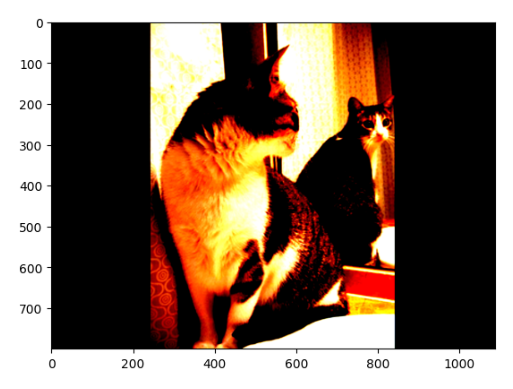

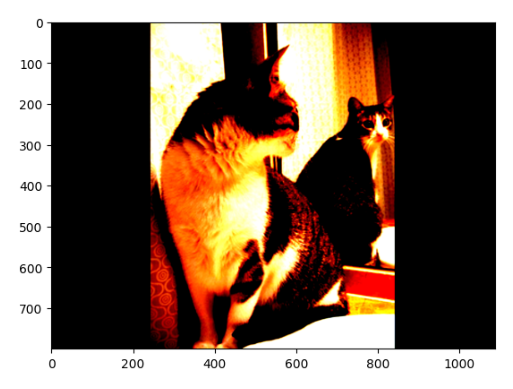

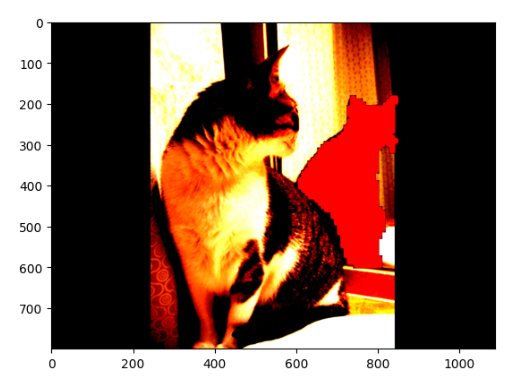

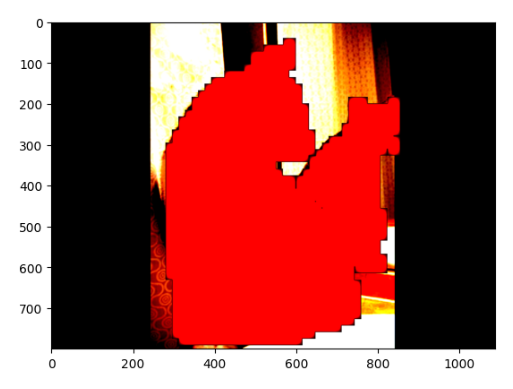

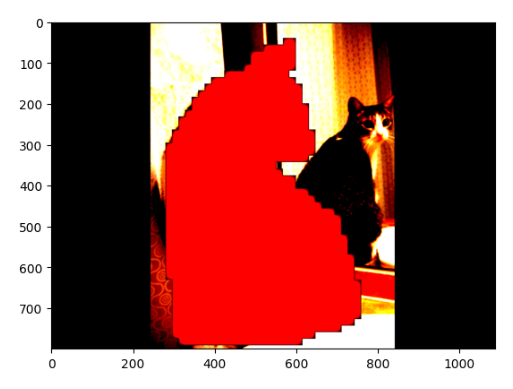

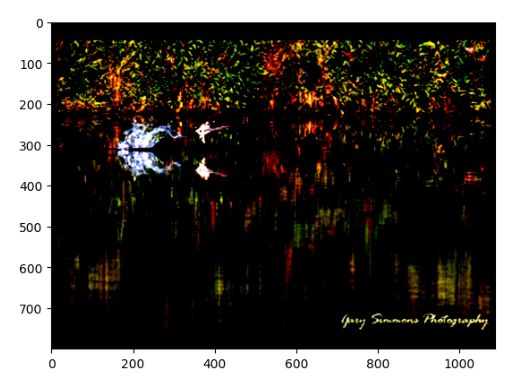

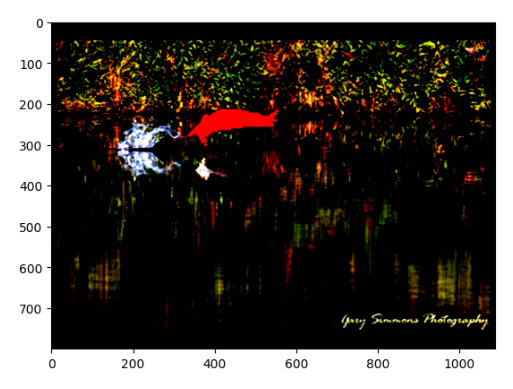

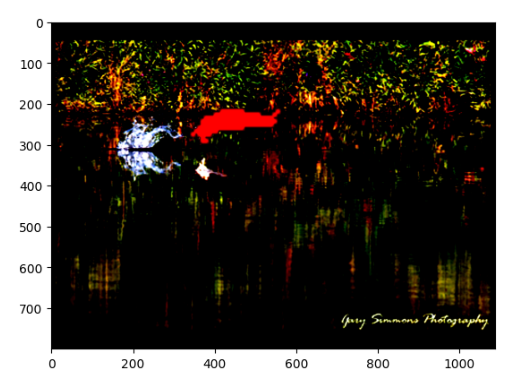

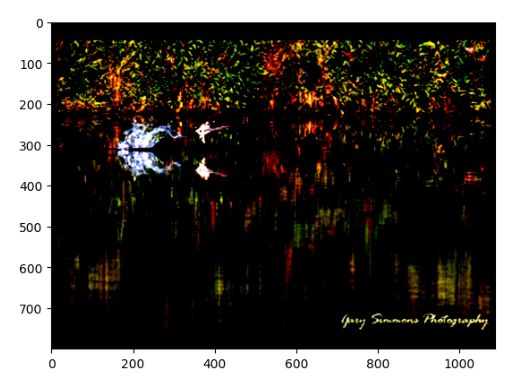

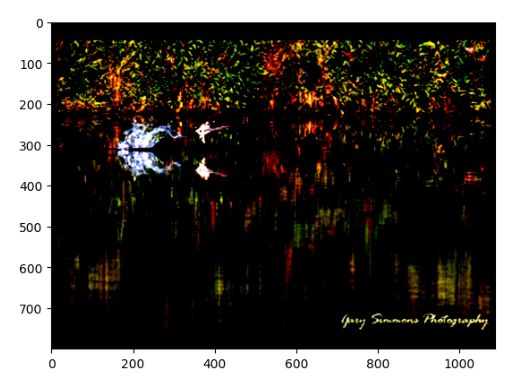

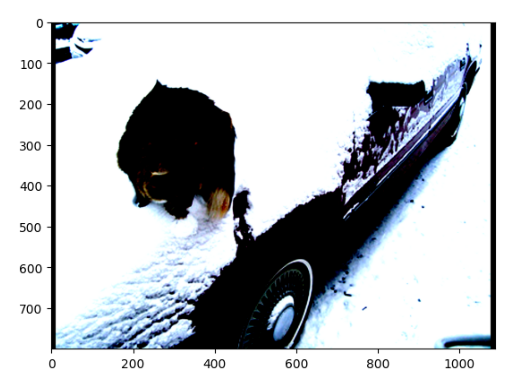

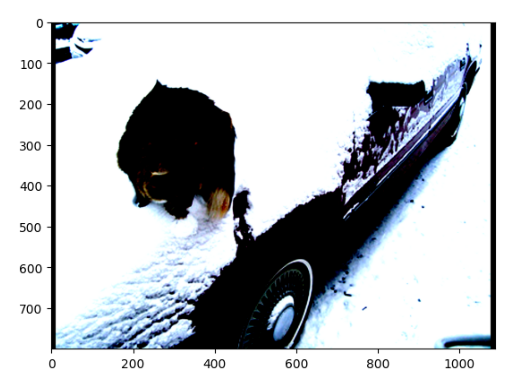

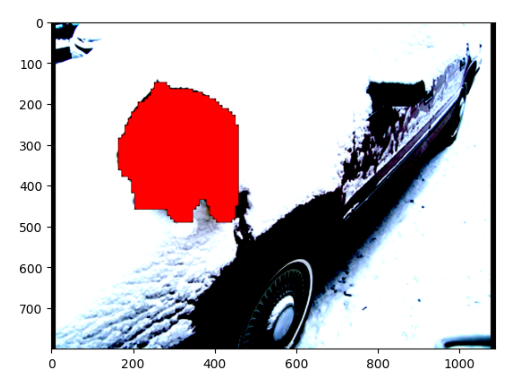

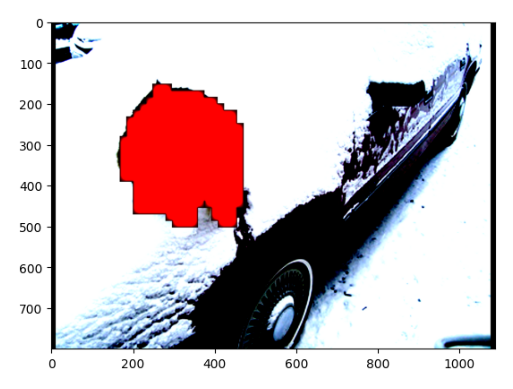

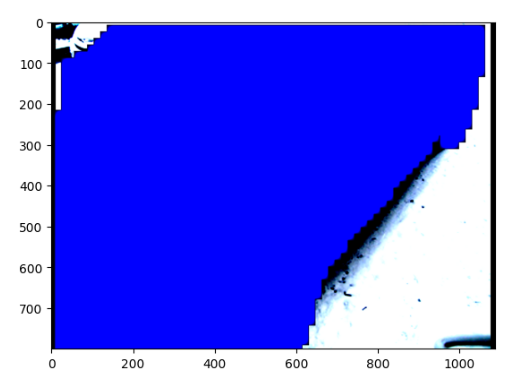

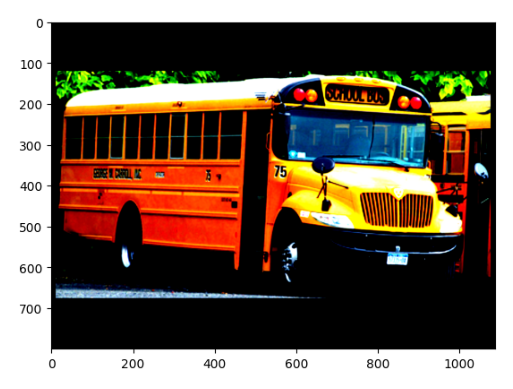

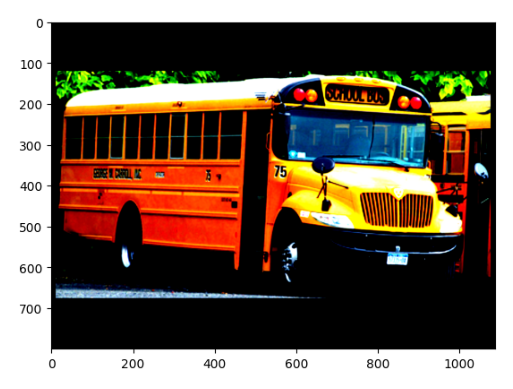

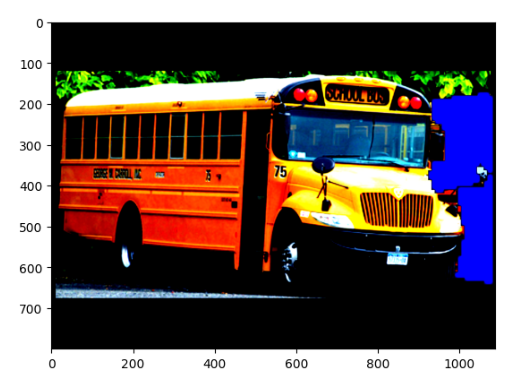

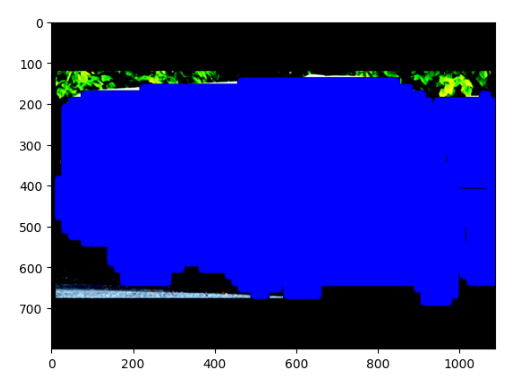

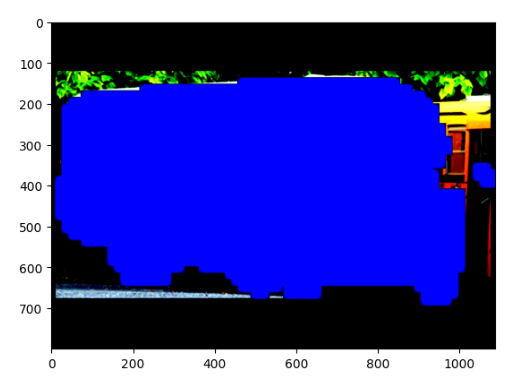

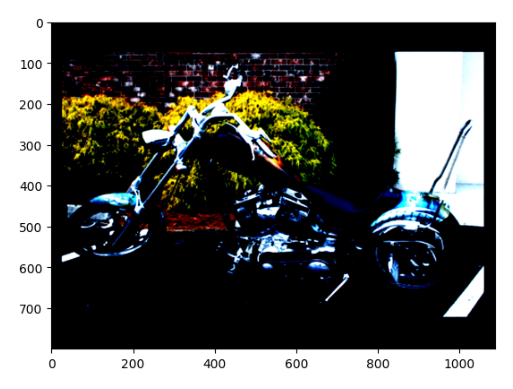

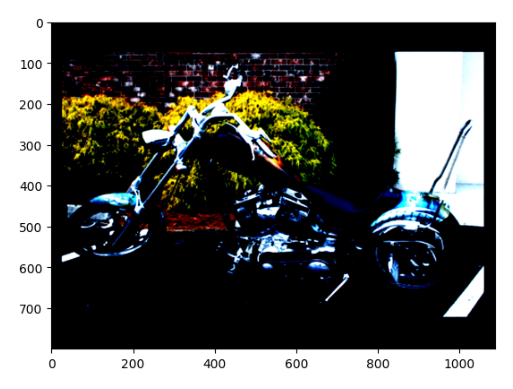

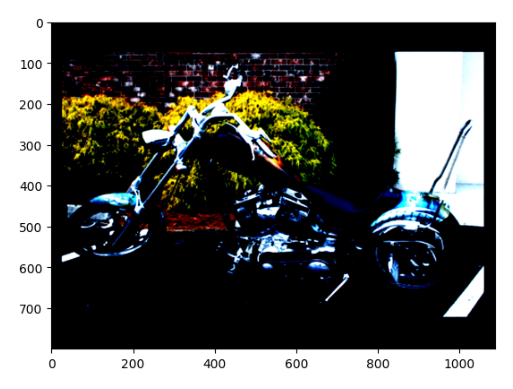

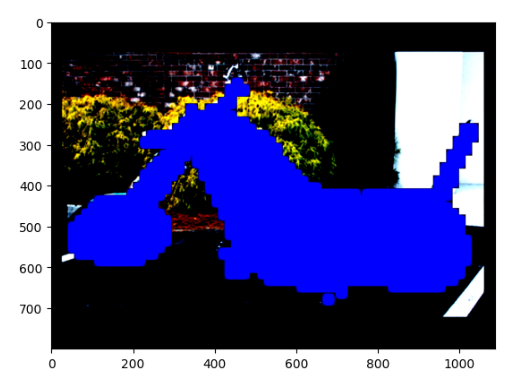

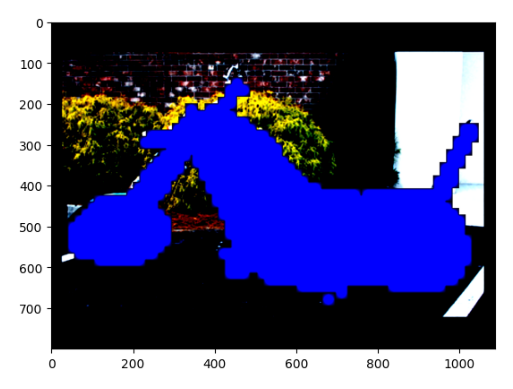

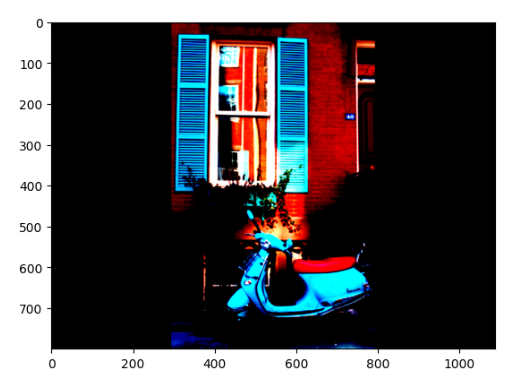

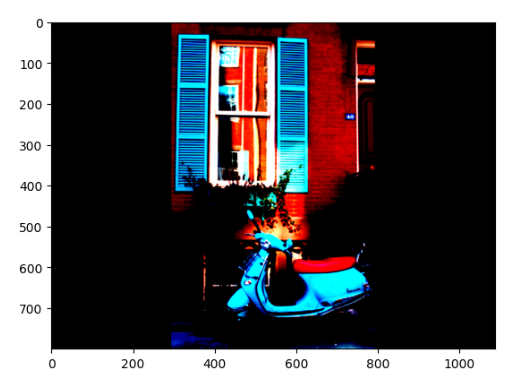

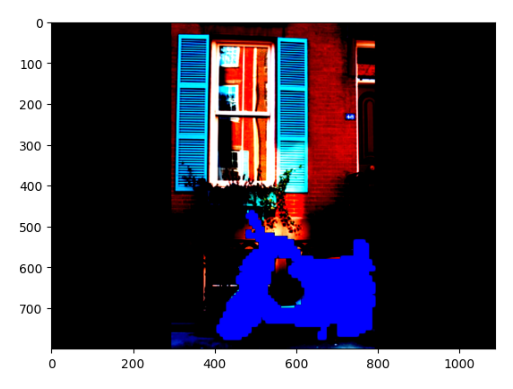

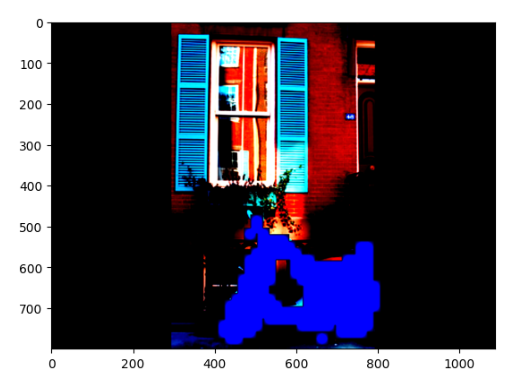

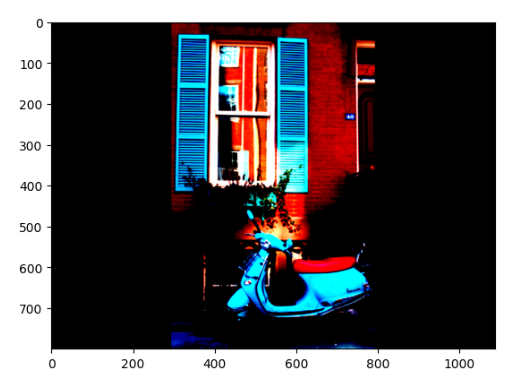

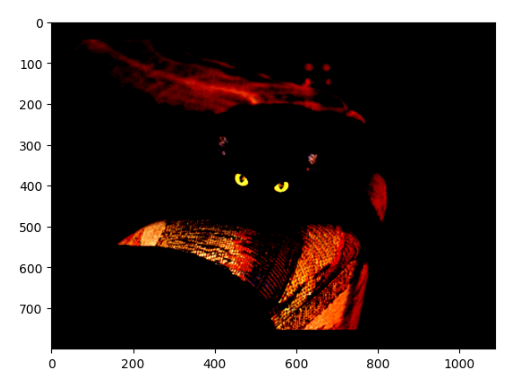

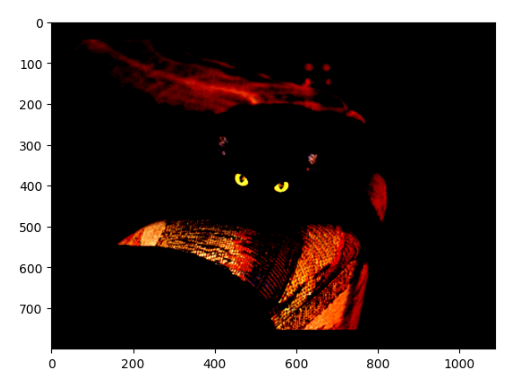

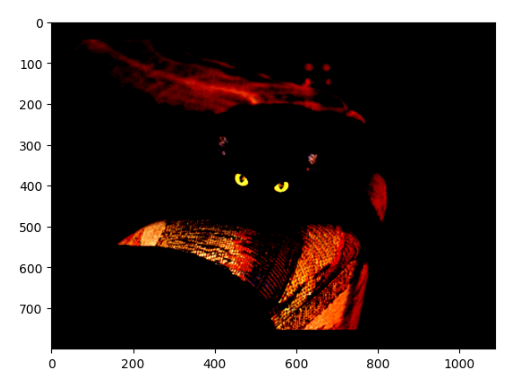

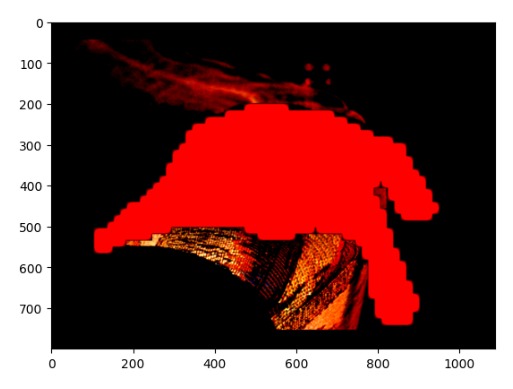

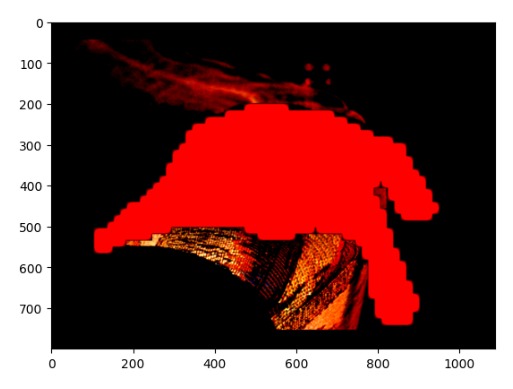

In [ ]:
# To generate target assignmnets
model = SOLO()
it = 0
for each_batch in (train_loader):
  image_set, label_set, mask_set, bbox_set = each_batch
  target_category, target_m, active_mask_ = model.generate_targets(bbox_set, label_set, mask_set)
  visualize_targets_data_sample(target_m, active_mask_, target_category, image_set)
  it += 1
  if it == 3:
    break

### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

To visualize that the data is loaded correctly, I have plotted few images to show which includes mask, annotations and bounding boxes. To get it we import the class "BuildDataset" and "BuildDataLoader" from dataset.py. Then using the "visualize_dataset_sample" function is used to display each image with annotation, mask and bounding mask. Alternatively, directly running the dataset.py will also generate & save these images. 

$ Note: change the path of data to be loaded according to your own directory.

To visualize target assignments, initalize the model SOLO and generate the required images using the functions generate_targets and visualize_target_data_sample.

In [24]:
torch.mps.empty_cache()
model = SOLO().to(device)

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='/content/drive/Shareddrives/cis 680 proj 3/',
    filename='model_{epoch:02d}',
    save_last=True
)

In [ ]:
epochs = 10
logger = pl_loggers.TensorBoardLogger("tb_logs", name="SOLO")
trainer = pl.Trainer(accelerator='auto', devices='auto', max_epochs=epochs, logger=logger, callbacks=[checkpoint_callback])
trainer.fit(model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type            | Params
---------------------------------------------------
0 | backbone       | BackboneWithFPN | 26.8 M
1 | category_convs | ModuleList      | 4.1 M 
2 | category_gn    | ModuleList      | 3.6 K 
3 | category_relu  | ModuleList      | 0     
4 | category_out   | ModuleList      | 6.9 K 
5 | mask_convs     | ModuleList      | 4.1 M 
6 | mask_gn        | ModuleList      | 3.6 K 
7 | mask_relu      | ModuleList      | 0     
8 | mask_out       | ModuleList      | 995 K 
---------------------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# PATH = 'model_full_working.pth'
# torch.save(model.state_dict(), PATH)

In [ ]:
# model = SOLO().to(device)
# wts = torch.load('/Users/ojasm/Desktop/UPenn/Fall 2023/CIS 680/project 3/code/model_epoch_epoch=04.ckpt', map_location=torch.device('cpu'))
# model.load_state_dict(wts['state_dict'])
# model.load_state_dict(wts)

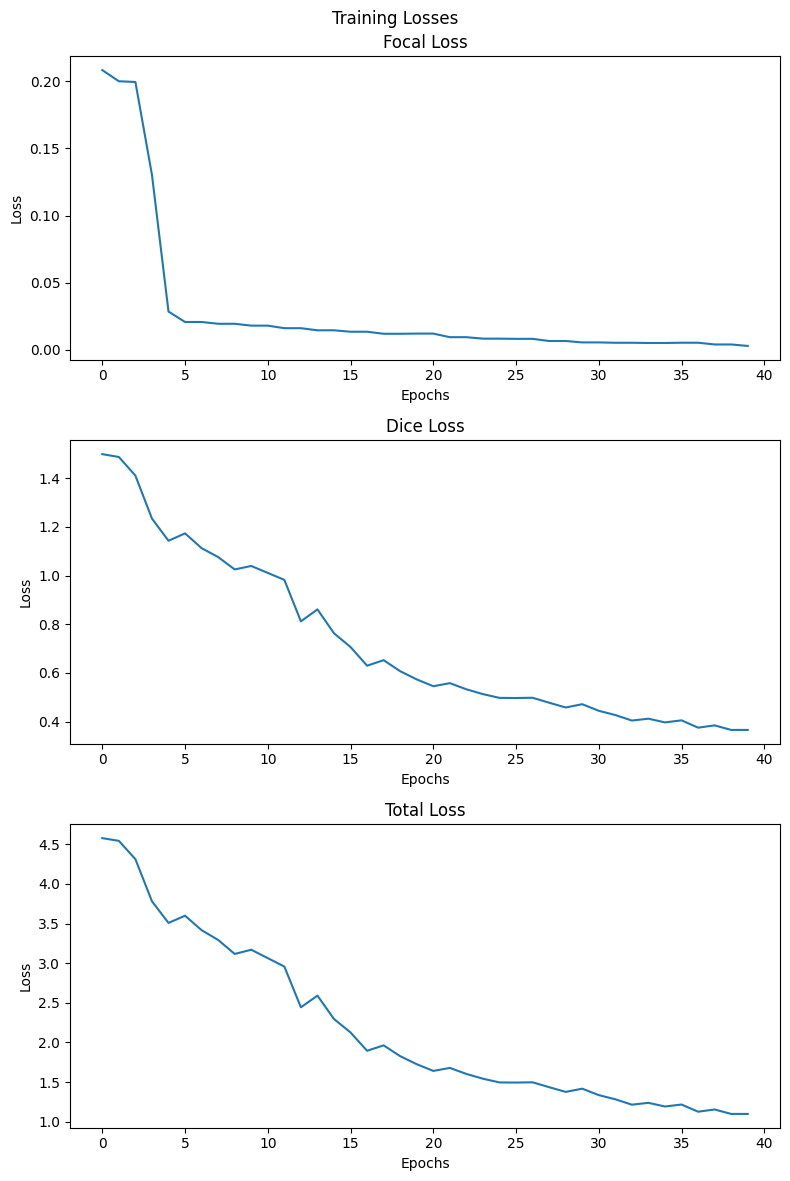

In [ ]:
# Training plots

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
fig.suptitle('Training Losses')
focal_loss_train = model.train_category_loss
ax1.plot(focal_loss_train, label='Focal Loss')
ax1.set_title('Focal Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

dice_loss_train = model.train_mask_loss
ax2.plot(dice_loss_train, label='Dice Loss')
ax2.set_title('Dice Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

tot_train_loss = model.train_loss
ax3.plot(tot_train_loss, label='Total Loss')
ax3.set_title('Total Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')

plt.tight_layout()
# plt.savefig('training_losses.png')
plt.show()


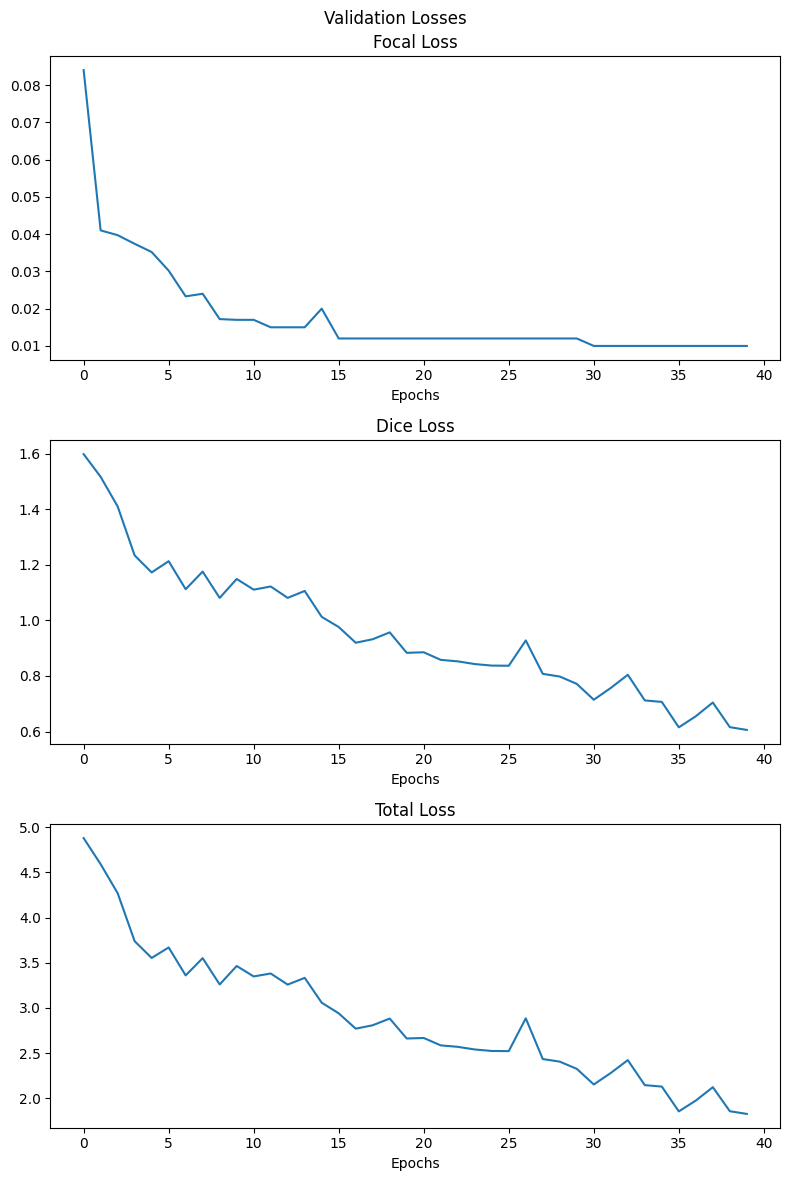

In [ ]:
# plot validation

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
fig.suptitle('Validation Losses')
val_focal = model.val_category_loss
ax1.plot(val_focal, label='Focal Loss')
ax1.set_title('Focal Loss')
ax1.set_xlabel('Epochs')

val_dice = model.val_msk_loss_epoch
ax2.plot(val_dice, label='Dice Loss')
ax2.set_title('Dice Loss')
ax2.set_xlabel('Epochs')

val_total = model.val_loss
ax3.plot(val_total, label='Total Loss')
ax3.set_title('Total Loss')
ax3.set_xlabel('Epochs')
plt.tight_layout()
# plt.savefig('validation_losses.png')
plt.show()

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [ ]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

def calculate_score(mask_thresh, cat_max_thresh):
    scores = []
    for mask_i_, cat_max_i in zip(mask_thresh.float(), cat_max_thresh.float()):
        val = mask_i_[mask_i_ > 0.]
        score = torch.mean(val * cat_max_i)
        scores.append(score)

    scores = torch.stack(scores)
    scores = torch.nan_to_num(scores, nan=0.)

    return scores

def sort_score(scores, mask_thresh, thresh_idx):
    score_sorted, sorted_idx = torch.sort(scores, descending=True)
    mask_sort = mask_thresh[sorted_idx]
    sorted_classes = thresh_idx[sorted_idx]

    return score_sorted, mask_sort, sorted_classes

def post_processing(category, masks):

    mask_ten = torch.cat(masks)
    cat_ten = []
    for cat_i in category:
        cat_ten.append(cat_i.view(-1, cat_i.size(-1)))
    cat_ten = torch.cat(cat_ten)
    
    cat_max, idx_max = torch.max(cat_ten, dim=1)
    idx_thesh = torch.where(cat_max > 0.1)[0]
    cat_max_thresh = cat_max[idx_thesh]
    cat_max_idx = idx_max[idx_thesh]
    masks_thresh = mask_ten[idx_thesh]

    scores = calculate_score(masks_thresh, cat_max_thresh)
    score_sorted, mask_sorted, class_sorted = sort_score(scores, masks_thresh, cat_max_idx)
    iou = MatrixNMS(mask_sorted, score_sorted)
    iou_sorted_score, iou_idx = torch.sort(iou, descending=True)
    class_iou_sort = class_sorted[iou_idx]
    mask_fpn_sort = mask_sorted[iou_idx]
    final_msks = F.interpolate((mask_fpn_sort[:2]).unsqueeze(0), size=(800, 1088), mode="bilinear")

    return final_msks, class_iou_sort[:2]
# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

def visualize(image, all_fpn_mask, classes):
  threshold=0.2
  beta=0.2
  trans_mask = torch.where(all_fpn_mask>threshold, 1, 0)
  for i in range(0, len(trans_mask[0])):
    iter_img = image.detach().cpu().numpy().copy()
    iter_img[classes[i]] = iter_img[classes[i]]*(np.where(trans_mask[0][i]==1, 0, 1)) + (np.where(trans_mask[0][i]==1, 255., 0))*(1-beta) + iter_img[classes[i]]*beta
    img = iter_img.squeeze().transpose(1,2,0)
  
  return np.clip(img, 0, 1)

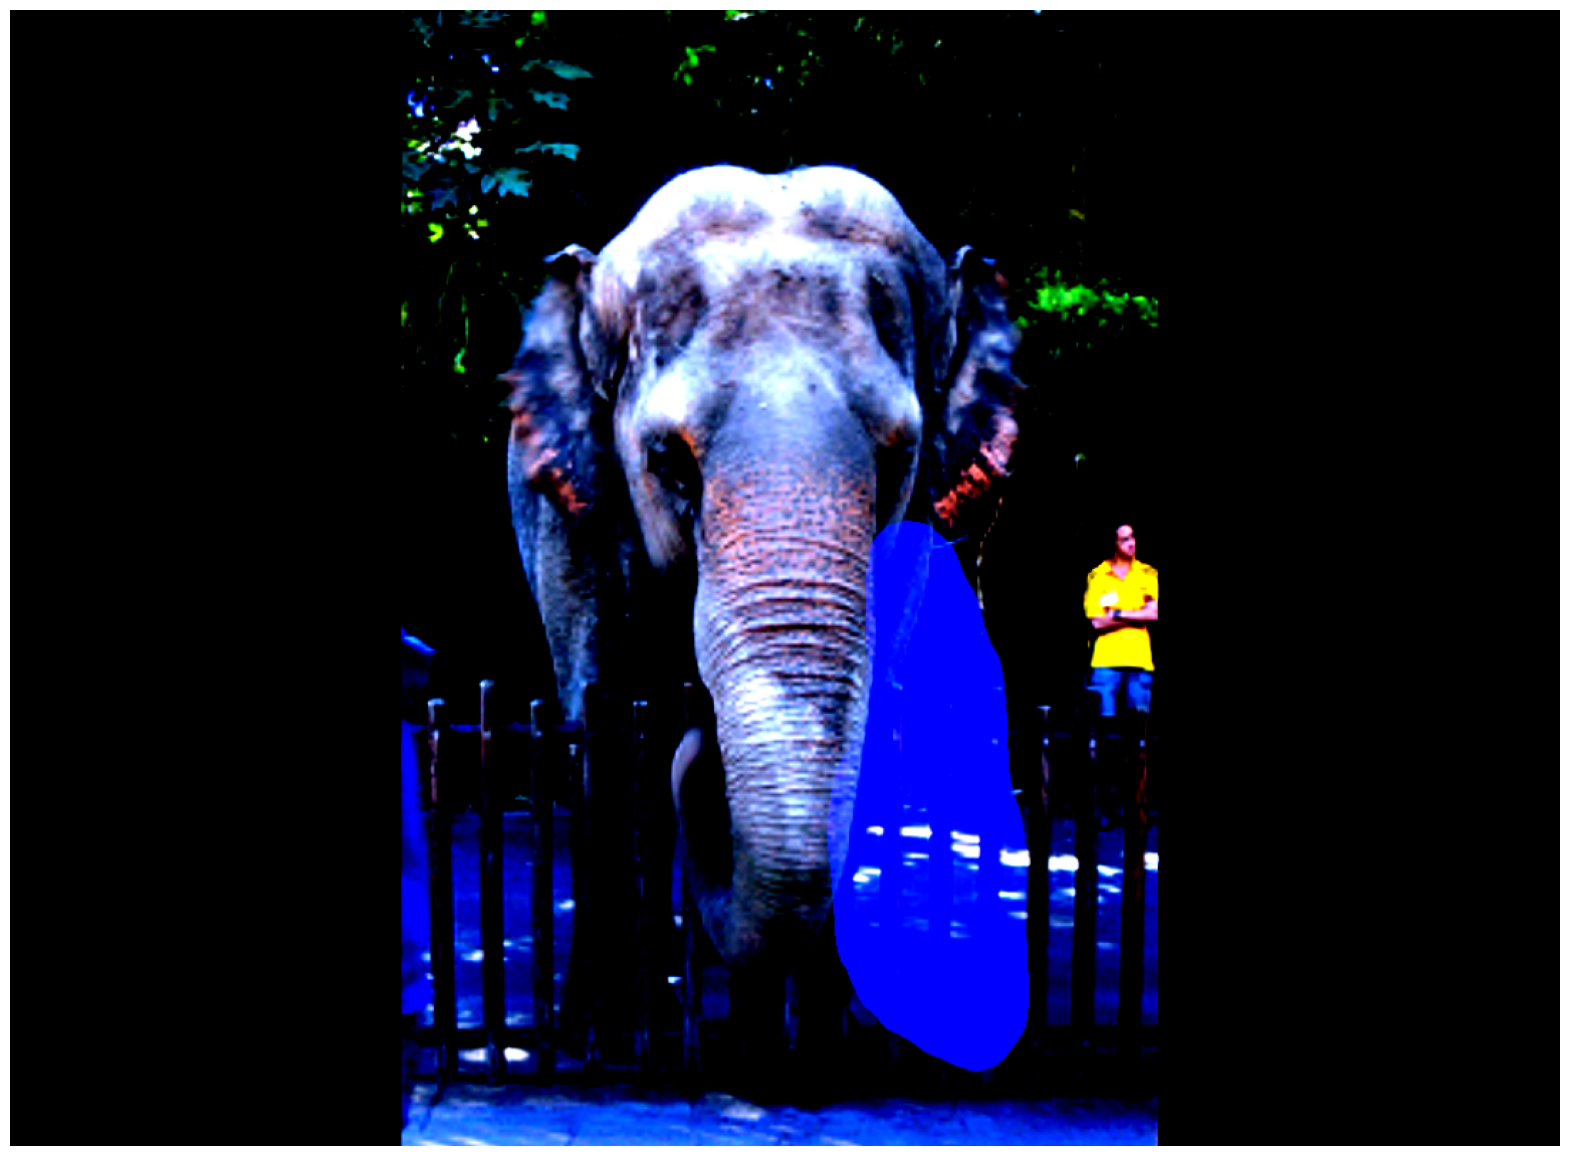

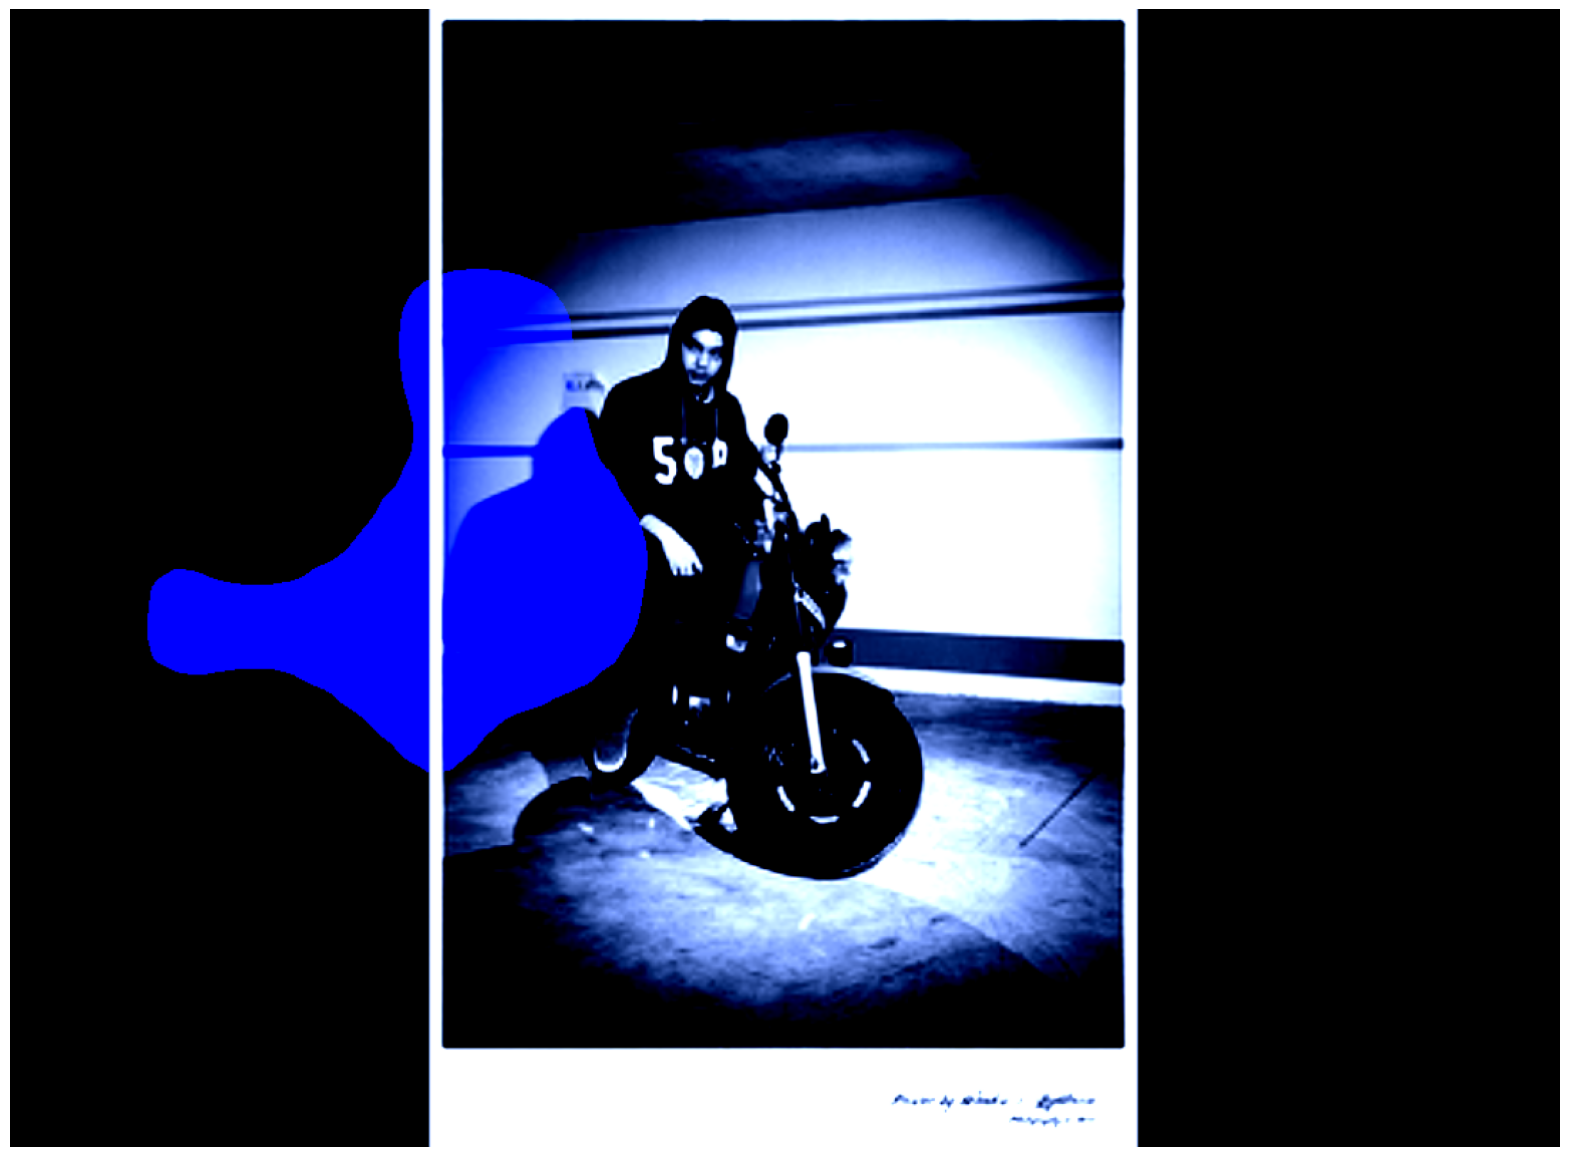

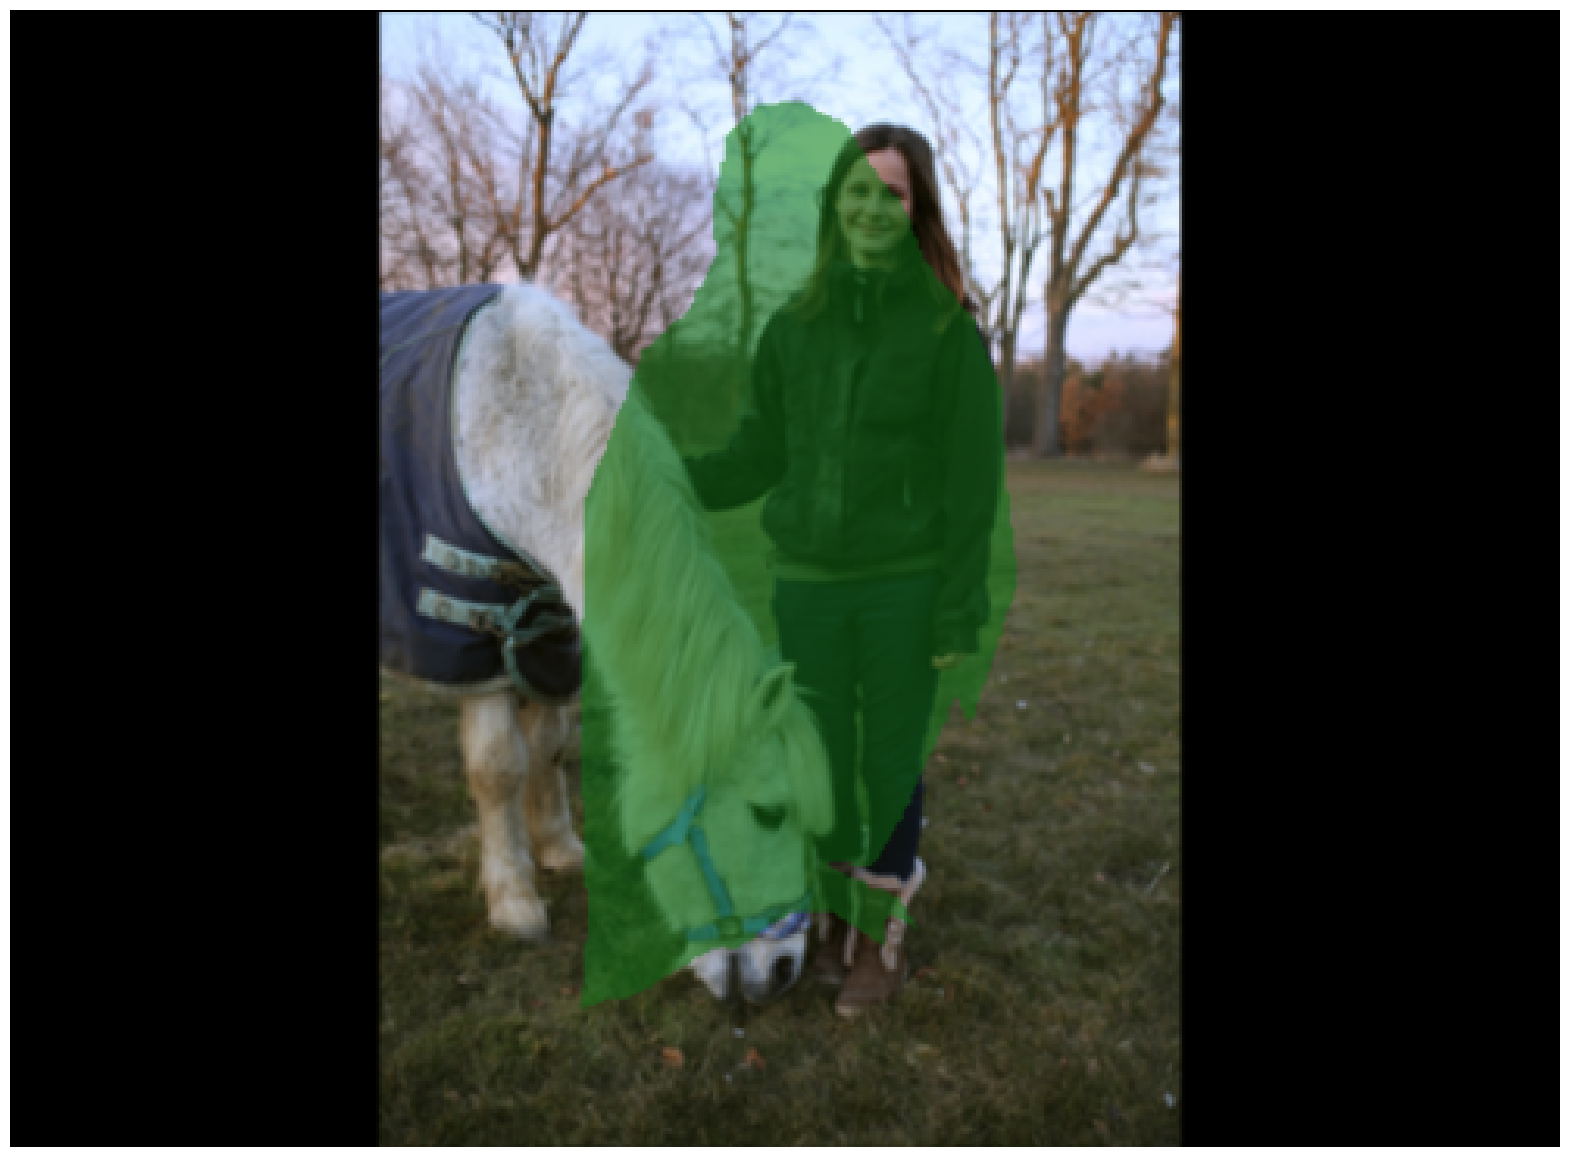

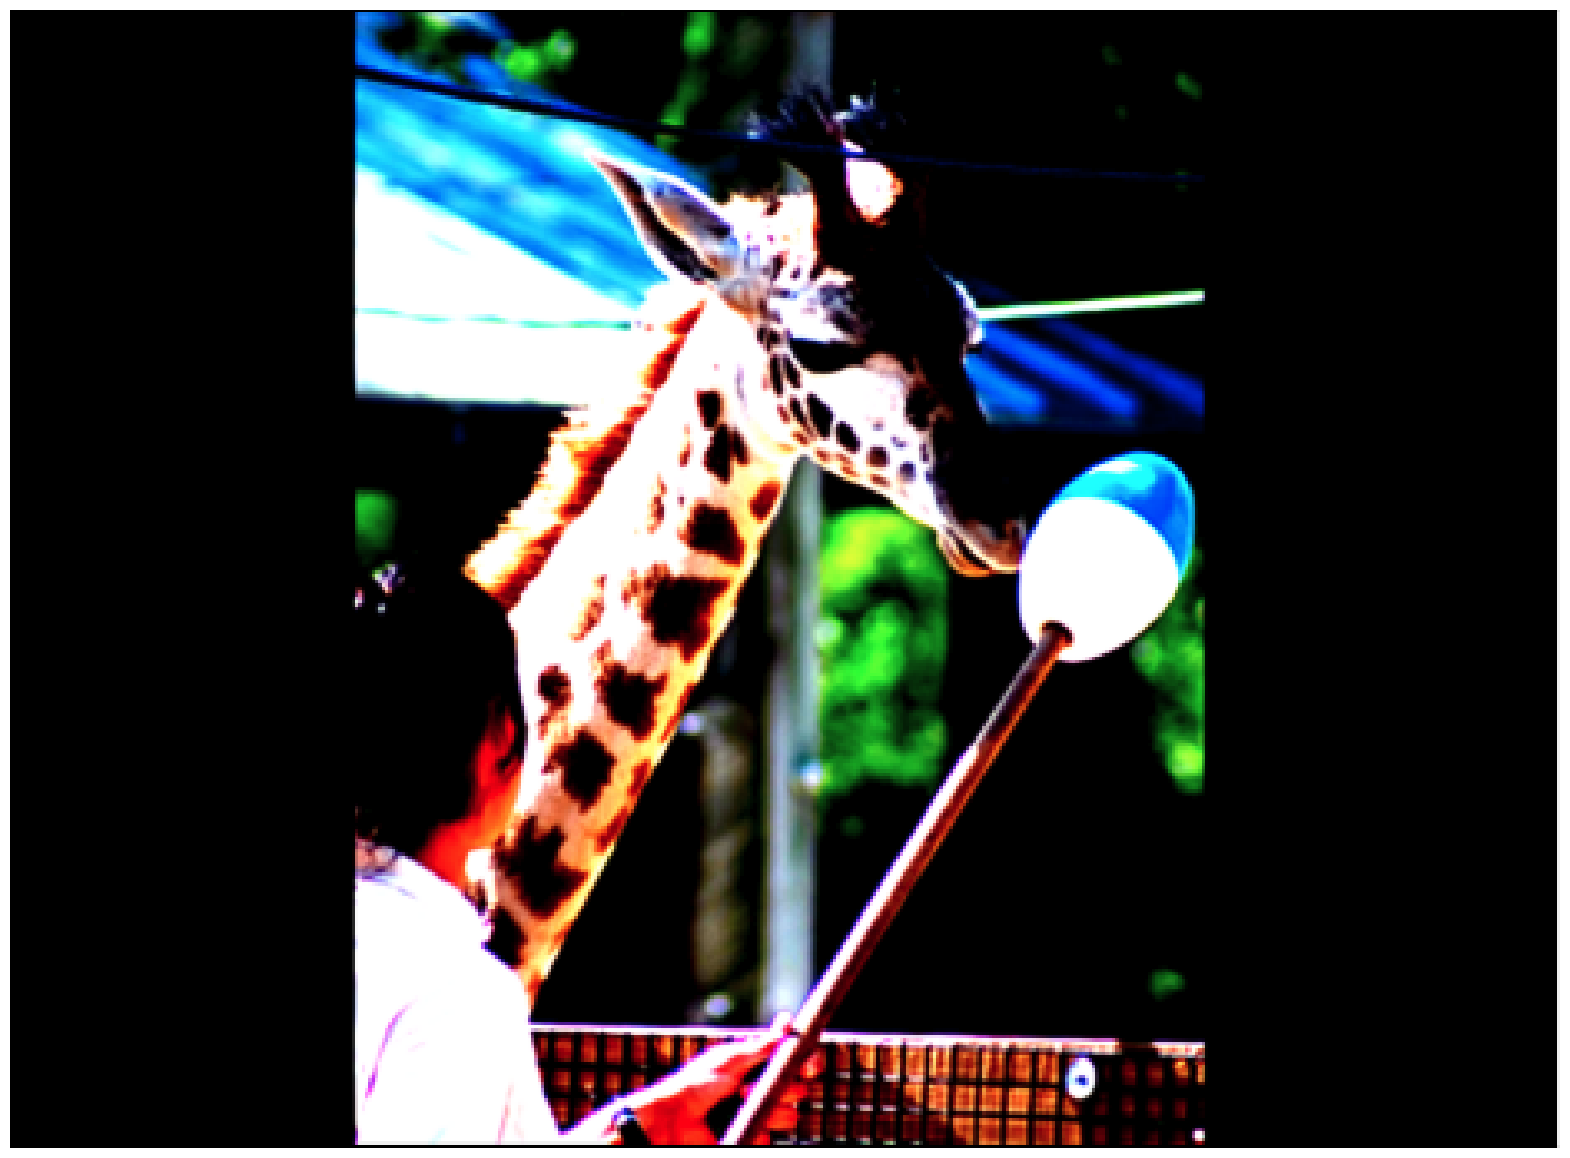

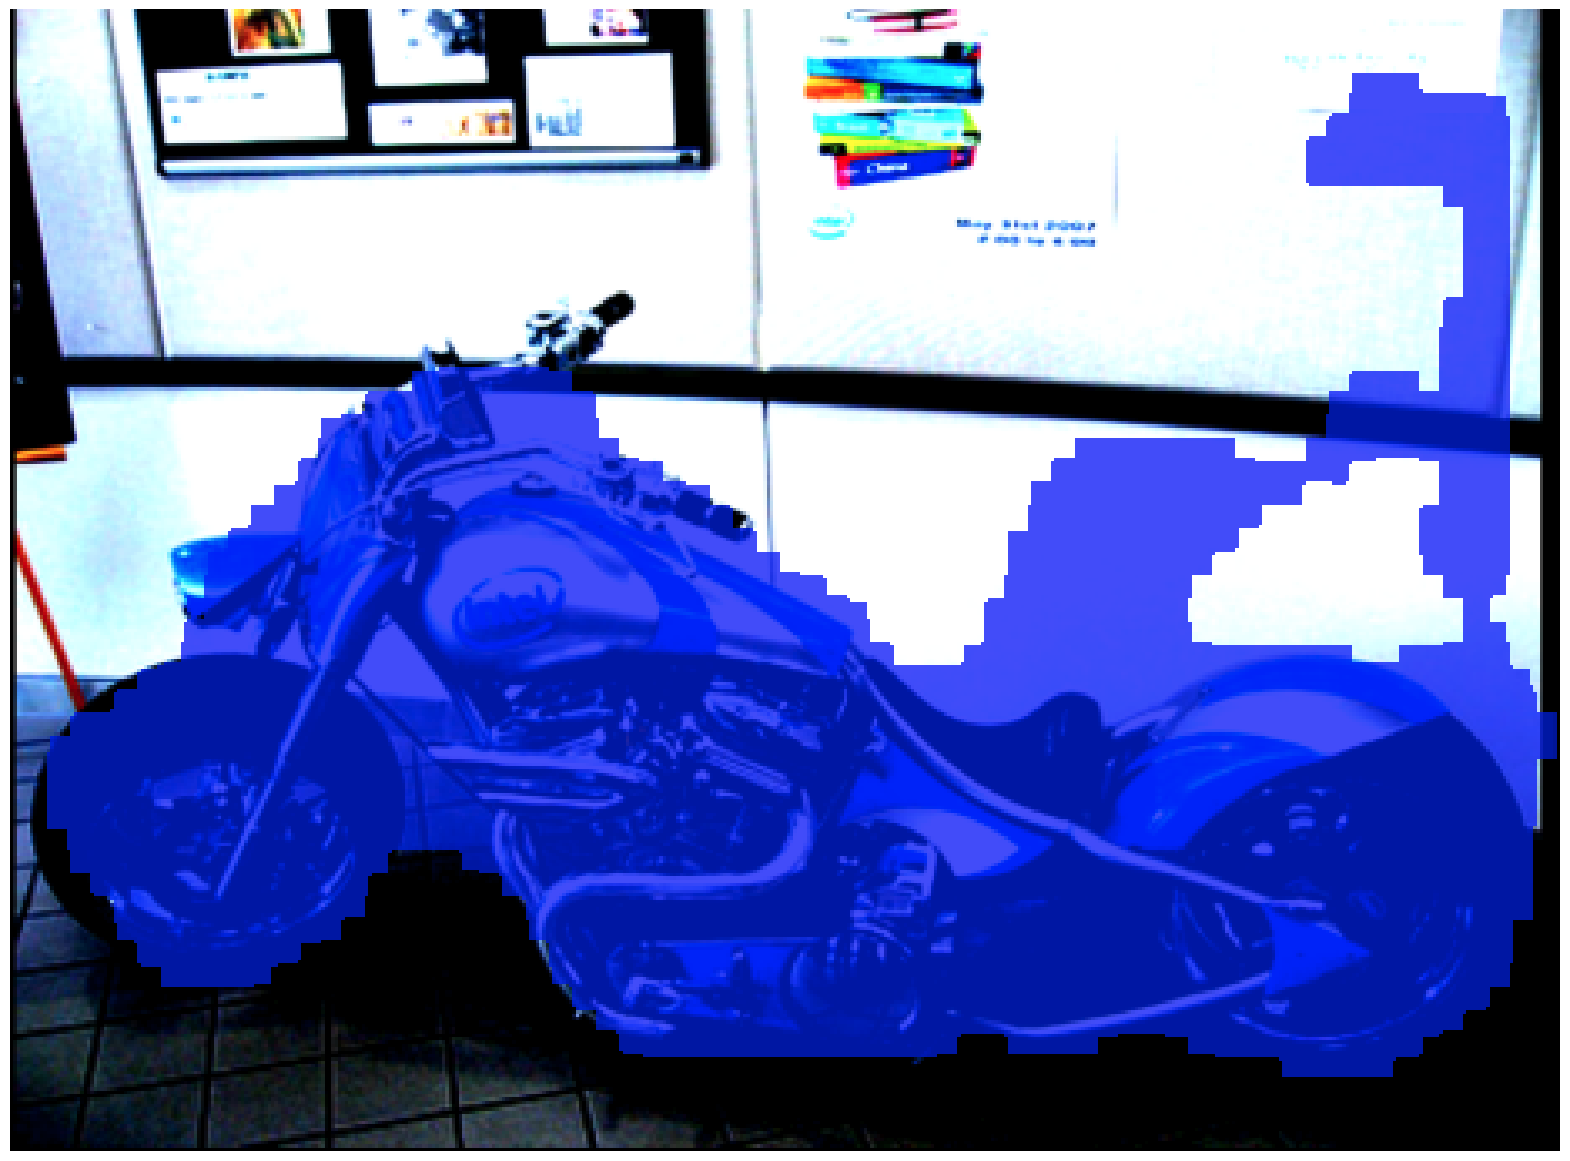

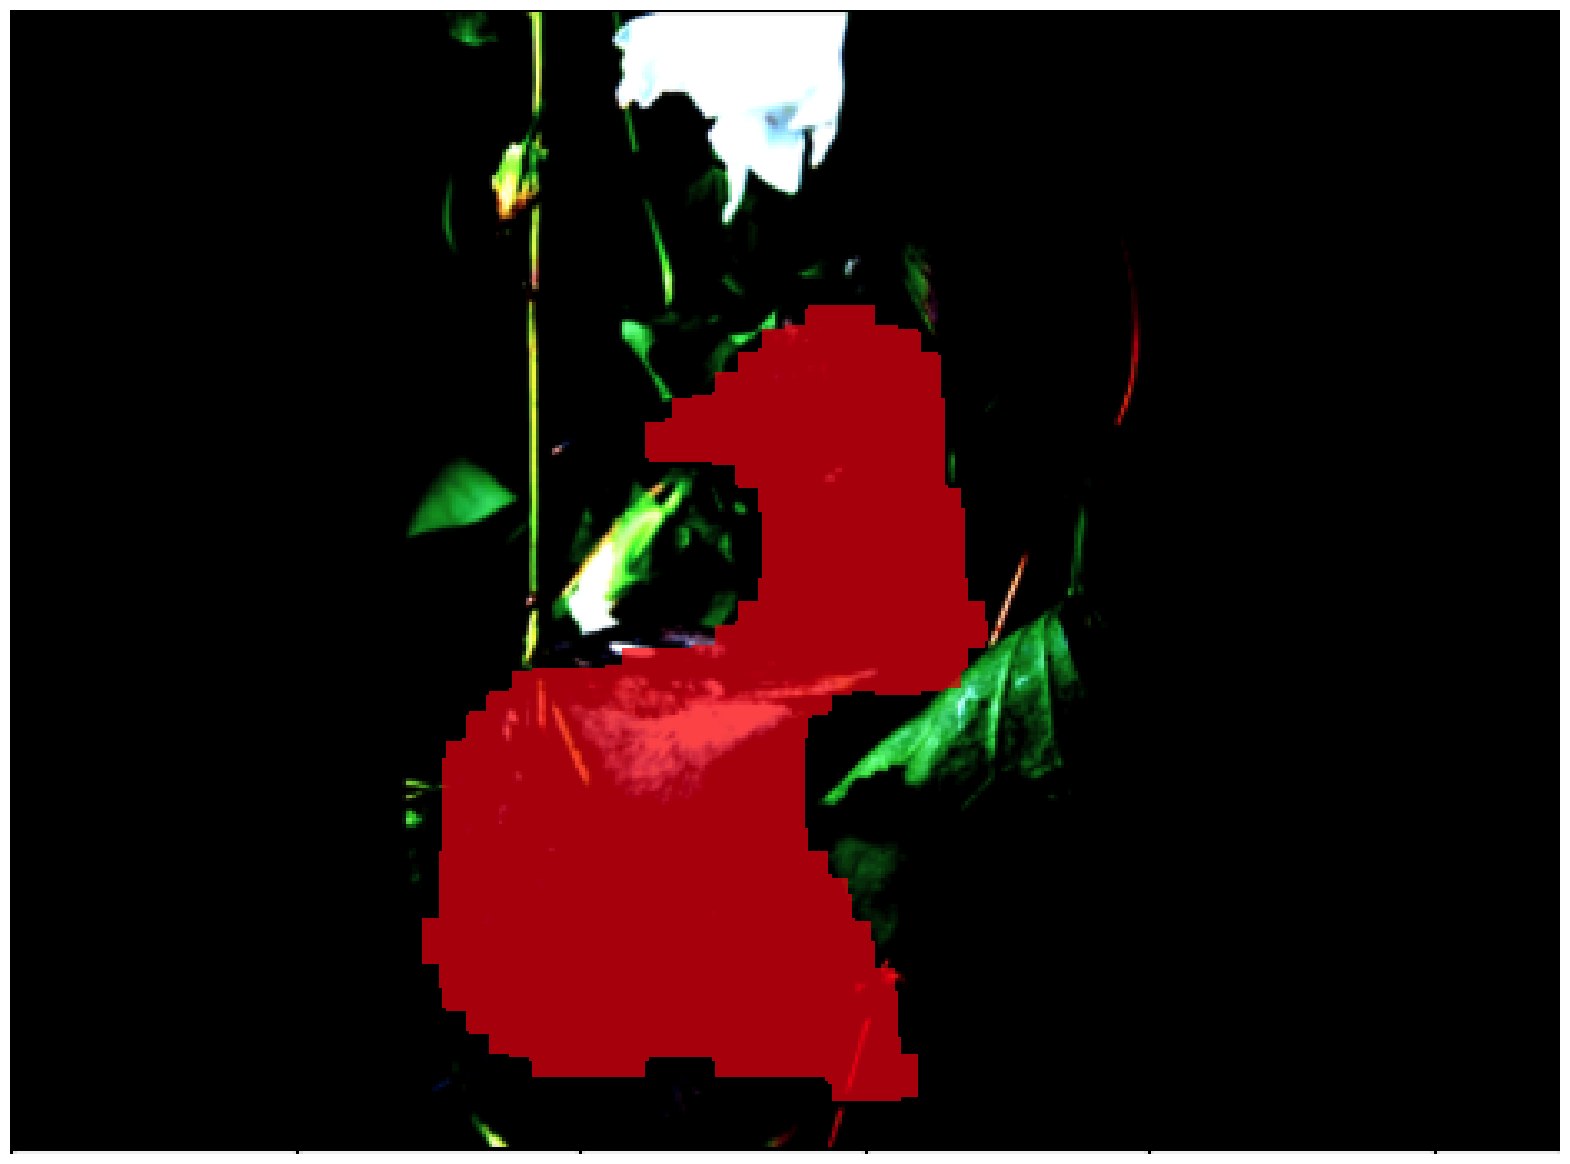

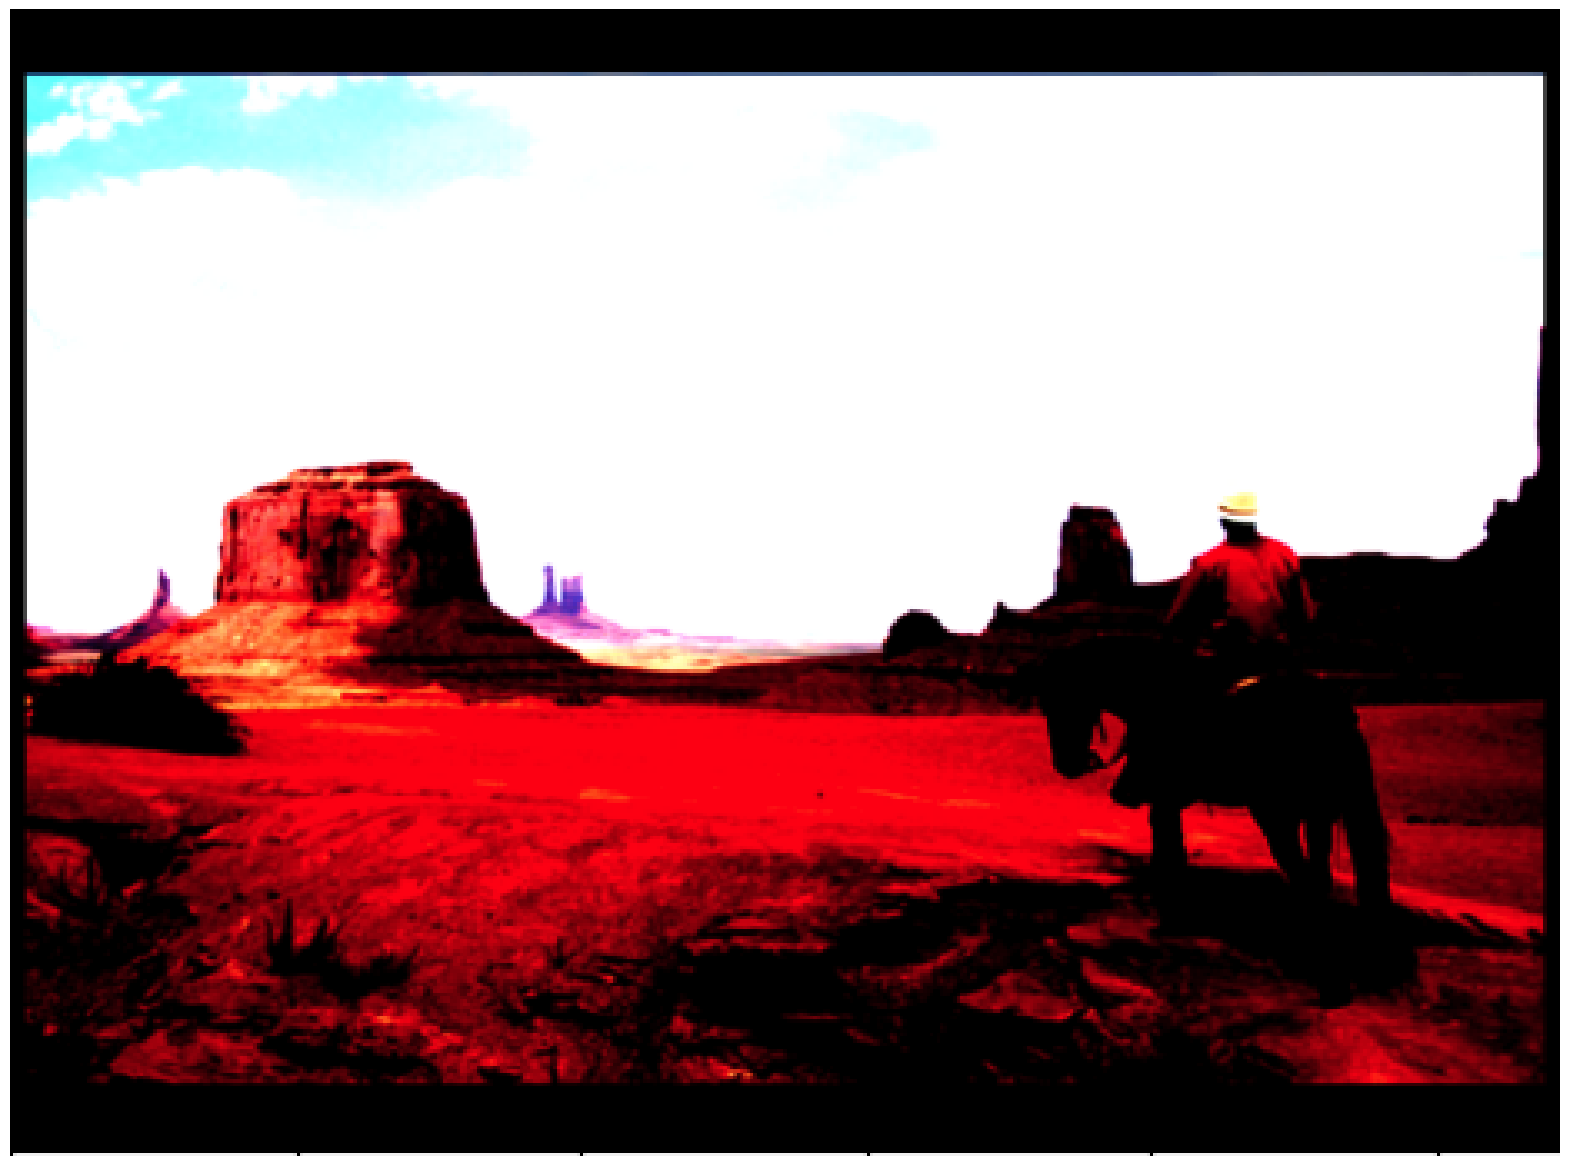

In [ ]:
# Visualizing the results
model.eval()
model.to(device)
it = 0
temp_flag = True
for i, batch_set in enumerate(test_loader):
  img_set, lab_set, mask_set, bbox_set = batch_set
  img_set = img_set.to(device)

  cat_tar, msk_tar, act_msk = model.generate_targets(bbox_set, lab_set, mask_set)
  cat_pred, msk_pred = model.forward(img_set, eval=True)

  for i in range(batch_size):
    img_val = img_set[i].squeeze(0)
    iou_pts = [points_nms(cat_pred[j][i].unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1) for j in range(5)]
    category_val = []
    mask_val = []
    for cat_i_fpn in iou_pts:
        category_val.append(cat_i_fpn.squeeze(0))
    for j in range(5):
        mask_val.append(msk_pred[j][i])
    if it == 1:
      temp_flag = False
      break
    try:
      disp_mask, disp_class = post_processing(category_val, mask_val)
      disp_img = visualize(img_val, disp_mask, disp_class)
      plt.figure(figsize = (20,20))
      plt.imshow(disp_img)
      plt.axis('off')
      it += 1
    except:
      continue
    
  if temp_flag == False:
    break 

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.


No changes have been made to architecture. The given architecture was followed. One observation was the focal loss had a very steep slope compared to other losses. One of the major problems faced in this project is GPU computational units. Large batch number would result in colab session crashing and small batches would more than 1 hour for a single epoch. Twice, after whole session of training, one minute mistake affected the entire training session, for example, one time loss would not decrease due to a minor error in loss function. Even locally the kernel would crash many times. Learned a lot about how to manage RAM, memory stuff. The performance of the model can be improved further by training it for more time using better computational power.

Chatgpt: Helped in undetsanding and breaking down the problem.

To reproduce the results, you need to train the model by creating an object of the SOLO class. The collect the request loss data from the model and plot it. 
To generate mask on test data, run the cell which has functions : point_nms, calculatescore, sort_score, post_processing, MatrixNMS and visualize; then run the below cell which calls visualize which takes batches of data and process it using point_nms, calculatescore, sort_score, post_processing, MatrixNMS to generate the images.